# Facial Keypoints Detection

#### Data Transformation and Augmentation. Evaluate on a simple CNN Architecture and then on VGG-16 based model.

In [99]:
import pandas as pd
import numpy as np
import sys, os, re, time, warnings
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy.ndimage import rotate
from scipy.ndimage import gaussian_filter
from math import sin,cos,pi
from skimage import exposure
from matplotlib import pyplot as plt
%matplotlib inline

# Set seed
np.random.seed(533)

In [100]:
#from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
from tensorflow import keras as keras
from keras import models, callbacks
from keras import Sequential, Model
from keras import optimizers, metrics
from keras.layers import Dense, Dropout, Activation, Flatten, InputLayer
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras import utils
from keras import backend as K
from keras.models import load_model
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Concatenate
from keras.layers import Embedding

#tf.test.gpu_device_name()
print("tensorflow version {}".format(tf.__version__))
print("keras version {}".format(keras.__version__))
print("python version{}".format(sys.version))

tensorflow version 2.1.0
keras version 2.2.4-tf
python version3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]


### Kaggle Setup 

In [ ]:
#Set some directories.
train_zip_path = '/kaggle/input/facial-keypoints-detection/training.zip'
test_zip_path = '/kaggle/input/facial-keypoints-detection/test.zip'
Id_table_path = '/kaggle/input/facial-keypoints-detection/IdLookupTable.csv'
sample_sub_path = '/kaggle/input/facial-keypoints-detection/SampleSubmission.csv'
extracted_files_path = '/kaggle/working'

In [ ]:
#Unzip train csv file to 'extracted_files_path'.
import zipfile
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_files_path)
#Unzip test csv file to 'extracted_files_path'.
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_files_path)

In [ ]:
# train and test datasets file paths
FTRAIN = extracted_files_path + '/training.csv'
FTEST = extracted_files_path + '/test.csv'
FLOOKUP = Id_table_path

In [ ]:
# Load the Kaggle data
print("Loading dataset..")
train = pd.read_csv(FTRAIN)
test = pd.read_csv(FTEST)
lookup = pd.read_csv(FLOOKUP)

### Other Env. Setup

Execute the steps for other environments.

In [4]:
# Input data file paths
FTRAIN = '../../../../data/training/training.csv'
FTEST = '../../../../data/test/test.csv'
FLOOKUP = '../../../../data/IdLookupTable.csv'

In [101]:
# Floyd Hub
# Input data file paths
FTRAIN = 'training.csv'
FTEST = 'test.csv'
FLOOKUP = 'IdLookupTable.csv'

In [102]:
# Load the Kaggle data
print("Loading dataset..")
train = pd.read_csv(os.path.expanduser(FTRAIN))
test = pd.read_csv(os.path.expanduser(FTEST))
# Load the lookup file
lookup = pd.read_csv(os.path.expanduser(FLOOKUP))

Loading dataset..


### Helper functions


In [103]:
# Function to load the dataset into numpy arrays
def load_dataset(test = False, drop_bad_data = True):
    
    filename = FTEST if test else FTRAIN
    
    print("Loading Data...")
    
    # Read the data into a pandas dataframe
    df = pd.read_csv(os.path.expanduser(filename))

    # 'Image' column has pixel values for input images separated by space which will be 
    # converted to numpy arrays
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    if not test:
        # Apply only on train data
        
        # Drop any bad data
        if drop_bad_data:
            bad_image_indices = [1877, 1907, 2199]
            cnt = 0
            for index in bad_image_indices:
                df = df.drop(df.index[index - 1 - cnt])
                cnt += 1
            # Drop rows with missing data
            df = df.dropna()
            
    # Scale the pixel values to be between 0, 1
    X = np.vstack(df['Image'].values) / 255.
    
    if not test:
        # Apply only on train data
        
        # Extract the labels(x, y coordinates of facial key points) from train data
        y = df[df.columns[:-1]].values
    
        # data with missing labels will be removed from train data
        X = X[~ np.isnan(y).any(axis=1)]
        y = y[~ np.isnan(y).any(axis=1)]
        X, y = shuffle(X, y, random_state=42)
        y = y.astype(np.float32)
     
    else:
        y = None
        
    X = X.reshape(-1, 96, 96, 1)
    X = X.astype(np.float32)

    # Return the train/test data and labels(only for train data)
    return X, y


# function to plot an image - NOT USED
def plot_image(x, y, axis):
    # Reshape input into a matrix of pixels
    img = x.reshape(96, 96)
    
    # Plot the pixels on gray scale
    axis.imshow(img, cmap = 'gray')
    
    # Mark the x and y co-ordinates with 'x' in red color
    
    # Rescale the co-ordinates for display
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=20, c='red')

# function to plot an image - NOT USED
def plot_image_2(image, y, axis):
    # Reshape input into a matrix of pixels
    #img = x.reshape(96, 96)
    #img = x
    
    # Plot the pixels on gray scale
    axis.imshow(image, cmap = 'gray')
    
    # Mark the x and y co-ordinates with 'x' in red color
    
    # Rescale the co-ordinates for display
    axis.scatter(y[0::2], y[1::2], marker='x', s=20, c='red')
    
# function to plot an image with train and predicted keypoints - NOT USED
def plot_predict(x, y, y_predict, axis):
    # Reshape input into a matrix of pixels
    img = x.reshape(96, 96)
    
    # Plot the pixels on gray scale
    axis.imshow(img, cmap = 'gray')
    
    # Mark the x and y co-ordinates with 'x' in red color
    
    # Rescale the co-ordinates for display
    axis.scatter(y[0::2], y[1::2], marker='o', s=20, c='red')
    axis.scatter(y_predict[0::2], y_predict[1::2], marker='o', s=20, c='yellow')
    
# function to get original kaggle train data - NOT USED
def get_orig_train_data():
    
    # Get the location of the train dataset
    fname = FTRAIN
    
    print("Loading data...")
    
    # Read data into pandas dataframe
    df = pd.read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # 'Image' column has pixel values for input images separated by space which will be 
    # converted to numpy arrays 
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    # Scale the pixel values to be between 0, 1
    X = np.vstack(df['Image'].values) / 255.  
    X = X.astype(np.float32)
    
    # Extract the labels(x, y coordinates of facial key points) from train data
    y = df[df.columns[:-1]].values
    
    # Scale the labels which are x,y coordinates of the facial key points to be between -1 and 1
    y = (y - 48) / 48  # scale target coordinates to [-1, 1]
    
    # Reshape the images
    X = X.reshape(-1, 1, 96, 96)

    return X, y  

# Function to plot predictions and generate kaggle submission file
def test_predict(model, model_name, keypoints = []):
    
    # split out image values from Kaggle test data
    image = []
    for i in range(test.shape[0]):
        img = test['Image'][i].split(' ')
        img = ['0' if j == '' else j for j in img]
        image.append(img)
    
    # Reshape for prediction
    X_test = np.array(image, dtype = 'float').reshape(-1,96,96,1)
    X_test.shape
    
    # predict on test data
    Y_test = model.predict(X_test)
    
    # Plot - Test Later
    #fig = plt.figure(figsize=(20, 20))
    #fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
   # for i in range(16):
   #     ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    #    img = X_test[i].reshape(96, 96)
    #    ax.imshow(img, cmap='gray')
    #    ax.scatter(Y_test[i, keypoints], Y_test[i, keypoints], marker='o', color = 'red', s=50, label = 'predict')
        
    #plt.show()
    
    return Y_test

# This generates a .csv file with predictions from Kaggle test data
# The generated .csv file is then submitted on Kaggle to get scores
def generate_submission(Y_test, model_name):
    # Generate submission file
    sub1_df = pd.DataFrame(Y_test, columns=train.columns[:-1])
    sub2_df = pd.concat([test['ImageId'], sub1_df], axis=1)
    sub3_df = pd.melt(sub2_df, id_vars=['ImageId'], value_vars=train.columns[:-1]).rename \
            (columns={"variable": "FeatureName", "value": "Location"})
    sub4_df = pd.merge(lookup.drop(columns=['Location']), sub3_df, on=['ImageId','FeatureName'], how='left')
    sub_final_df = sub4_df[['RowId', 'Location']]

    print(sub_final_df.shape)
    sub_final_df.head()
    # Save the file
    sub_final_df.to_csv(model_name+'.csv', index=False)

# This function is used to plot metrics of trained models
# The metrics used here are RMSE(train data) and Val RMSE(validation)
# It has an option to print the accuracy as well if accuracy = True
def plot_metrics(model_name, history, accuracy = True):
    # plot metrics
    plt.plot(history.history['rmse'], label = 'Train')
    plt.plot(history.history['val_rmse'], label = 'Dev')
    plt.legend(loc="best")
    plt.xlabel("epochs")
    plt.ylabel("rmse")
    plt.title(model_name)
    plt.show()

    print('Val RMSE: {}'.format(min(history.history.get('val_rmse'))))
    print('Train RMSE: {} '.format(min(history.history.get('rmse'))))
    if accuracy == True:
        print('Val Accuracy: {}'.format(max(history.history.get('val_accuracy'))))
        print('Train Accuracy: {} '.format(max(history.history.get('accuracy'))))
        


In [1]:
# Model Helpers
# This function takes 2 models each for the split datasets and makes predictions on test/validation data and
# plots the results
def model_predict(model_d1, model_d2, Xval, Yval, index, d1_label_indices, d2_label_indices, title):
    # Get model predictions
    y_d1 = model_d1.predict(Xval[index].reshape(-1, 96, 96, 1))
    y_d2 = model_d2.predict(Xval[index].reshape(-1, 96, 96, 1))
    
    # Combine both results
    y_comb = np.zeros((1, 30), dtype = np.float32)
    y_comb[:, d1_label_indices] = y_d1
    y_comb[:, d2_label_indices] = y_d2
    
    # Plot
    fig = plt.figure(figsize=(5, 5))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
    img = Xval[index].reshape(96, 96)
    ax.set_title(title)
    ax.imshow(img, cmap='gray')
    ax.scatter(Yval[index][range(0,30,2)], Yval[idx][range(1,30,2)], marker='o', s = 20, color='b')
    ax.scatter(y_comb[0][range(0,30,2)], y_comb[0][range(1,30,2)], marker='o', s = 20, color='r')

    plt.show()
    
# This function creates Simple_CNN_Aug model to test data augmentation techniques
# It takes train X, Y and val X, Y with batch size, number of epochs
def train_simple_cnn(Xtrain, Ytrain, Xval, Yval, points, model_code, model_name, simple_models_history_pd, batch_size, epochs):
    
    # Call function Simple_CNN_Aug to create model using the 'points'(keypoints) to train
    model = Simple_CNN_Aug(points)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'accuracy'])
    
    # Train the model
    train_history = model.fit(Xtrain, Ytrain, epochs=epochs, shuffle=False, batch_size=batch_size, \
                              validation_split = 0, validation_data = (Xval, Yval), \
                              callbacks=[early_stop], verbose=2)
    
    # Call function to plot metrics of results
    plot_metrics(model_name, train_history, True)

    # Append history to pd 
    hist = pd.DataFrame(train_history.history)
    hist['Model_Name'] = model_name
    hist['Model_Code'] = model_code
    hist['Val_RMSE'] = min(hist.val_rmse)
    hist['RMSE'] = min(hist.rmse)
    simple_models_history_pd = pd.concat([simple_models_history_pd, hist])
    
    return model

def train_vgg16_2(Xtrain, Ytrain, Xval, Yval, points, model_code, model_name, cnn_models_history_pd, batch_size, epochs):
    
    print("====== " + model_name + " ======= \n")
    model = VGG_16_2(points)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'accuracy'])
    
    train_history = model.fit(Xtrain, Ytrain, epochs=epochs, shuffle=False, batch_size=batch_size, \
                              validation_split = 0, validation_data = (Xval, Yval), \
                              callbacks=[early_stop, reduce_lr], verbose=2)
    
    # Call function to plot metrics of results
    plot_metrics(model_name, train_history, True)

    hist = pd.DataFrame(train_history.history)
    hist['Model_Name'] = model_name
    hist['Model_Code'] = model_code
    hist['Val_RMSE'] = min(hist.val_rmse)
    hist['RMSE'] = min(hist.rmse)
    cnn_models_history_pd = pd.append([simple_models_history_pd, hist])
    
    return model

## Dataset

- The input images are 96x96 pixels in the range from 0 - 255.
- The following 15 keypoints, represented in (x,y) coordinates, should be predicted. They are in the range of 0-96.

  left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip
  
  

- 7049 training images and 1783 testing images 

#### Preprocess the input Kaggle train data

Here the kaggle data is pre-processed by splitting the input train dataset into Input images(features) and keypoints(x, y co-ordinates) for the 15 facial keypoints which will be the labels. The pixel values are normalized to be between 0 and 1 for further processing. 

In [104]:
# Call function to split the input train data from Kaggle into input images and keypoint labels for training.
X_training, Y_training = load_dataset(test = False)
print("X_Training: " + str(X_training.shape) + " Y_Training: " + str(Y_training.shape))

Loading Data...
X_Training: (2138, 96, 96, 1) Y_Training: (2138, 30)


#### Load and pre-process the Kaggle test data
The kaggle test data has only the input images for which we have to predict the keypoint labels. The pixel values for the images are normalized to be between 0 and 1 consistent with our pre-processed train data above.

In [105]:
# Load the pre-processed test data 
test_data, _ = load_dataset(test = True)
print("Test Images: " + str(test_data.shape))

# Reshape for prediction
X_test_kaggle = test_data
X_test_kaggle.shape

Loading Data...
Test Images: (1783, 96, 96, 1)


(1783, 96, 96, 1)

## Data Transformation

In this section, the following data transformation techniques are explored with the motivation of applying one or more combinations of techniques on the pre-processed kaggle train data and augment it, which can help improve the performance of our models. 

    - 1. Horizontal Flipping( Mirroring) of images and keypoints
    - 2. Rotation at 5, 10, 12, 15 degrees of Images and keypoints
    - 3. Histogram Equalization of image pixels
    - 4. Blurring or adding noise to images

In [106]:
# Random image index for augmentation plotting
image_index = 51

### 1. Horizontal Flipping(Mirroring)

This transformation horizontally flips the image on the x-axis by inverting the pixels so the transformed image looks like a mirrored one. The pixels for the keypoints are also flipped to correspond with the mirrored image. 


In [107]:
# Function to flip only the image horizontally
def flip_images(images):
    # Flip the image horizontally by inverting the pixels
    flip_images = np.copy(images)
    return flip_images.reshape(-1,96,96)[:, :, list(range(95, -1, -1))].reshape(-1, 96*96)

# Function to flip the keypoint coordinates
# eg. left_eye_center_x with index 0 will be swapped with right_eye_center_x with index 2 
# Note: Only 'x' co-ordinates will be swapped. 'y' co-ordinate will be same as we are doing horizontal flip.
def flip_keypoints(keypoints, n_points):
    keypoints_flip = keypoints.copy()
    # x-coordinate flip is just 96-x. y-coordinate remains the same
    keypoints_flip[:, list(range(0, n_points-1, 2))] = 95 - keypoints[:, list(range(0, n_points-1, 2))]
    return keypoints_flip

In [108]:
# Call function to apply flipping on train data
X_train_flip = flip_images(X_training)
Y_train_flip = flip_keypoints(Y_training, 30)

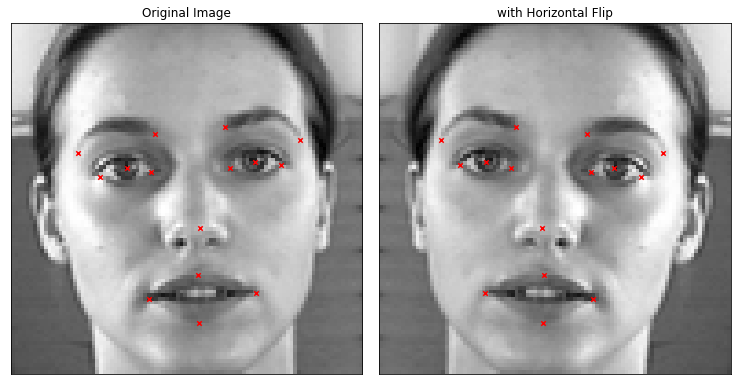

In [109]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_training[image_index].reshape(96,96),cmap='gray')
ax.scatter(Y_training[image_index, range(0, 30, 2)], Y_training[image_index, range(1, 30, 2)], marker = 'x', s=20, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Horizontal Flip')
ax.imshow(X_train_flip[image_index].reshape(96,96),cmap='gray')
ax.scatter(Y_train_flip[image_index, range(0, 30, 2)], Y_train_flip[image_index, range(1, 30, 2)], marker = 'x', s=20, color='r')

plt.show()

### 2. Rotation

With Rotation, the image and the pixel co-ordinates are rotated at a given angle. This is done as there images in the training data with various face positions and angles. By augmenting such transformed features while training our models, we could expect improvement while making more predictions.

In [110]:
# Based on the index of the image in the dataset, the direction of degree of rotation will be done.
# For even numbered indices, the images and keypoints will use +degree rotation.
# For odd numbered indices, the images and keypoints will use -degree rotation.
# This way the augmented dataset will have images rotated in both directions.

# Rotate images at given 'degree' angle
def rotate_images(images, degree, flag):
    
    # create an array for rotated images
    rotated_images = np.zeros((images.shape), dtype=np.float32)
    
    # For each image rotate at angle of given degree 
    # Need to keep the limit between the pixel limits
    for i in range(rotated_images.shape[0]):
        # For even numbered indexes, keep the input degree
        # For odd numbered indexes, use - degree
        if i%2 == 0:
            angle = degree
        else:
            angle = -degree
        
        if flag == True:
            rotated_images[i] = np.clip(rotate(images[i], angle, reshape=False, \
                                               mode='constant'), 0, 1)  
        else:
            rotated_images[i] = np.clip(rotate(images[i], angle, \
                                               mode='constant', cval=150).reshape(96*96), 0, 1)  
                                        
    return rotated_images
        
    
# Rotate the facial keypoint coordinates at given degree angle
def rotate_keypoints(keypoints, degree, n_points):
    
    # create an array for rotated keypoint coordinates
    rotated_keypoints = np.zeros((keypoints.shape), dtype=np.float32)
    
    # define rotation angle and center of rotation
    #theta = np.radians(degree)
    center_x = 95/2
    center_y = 95/2

    # Loop through each keypoint and do rotation
    for i in range(rotated_keypoints.shape[0]):
        # For even numbered indexes, keep the input degree
        # For odd numbered indexes, use - degree
        if i%2 == 0:
            theta = np.radians(degree)
        else:
            theta = np.radians(-degree)
            
        # obtain x and y coordinates from dataset
        x = keypoints[i][np.arange(0, n_points-1, 2)]
        y = keypoints[i][np.arange(1, n_points, 2)]

        # use rotation matrix to rotate coordinates around center
        new_x = np.cos(theta) * (x - center_x) + np.sin(theta) * (y - center_y) + center_x
        new_y = -np.sin(theta) * (x - center_x) + np.cos(theta) * (y - center_y) + center_y
        
        # put x and y back in original shape
        rotated_keypoints[i] = np.vstack((new_x, new_y)).transpose().flatten()
        
    return rotated_keypoints

In [111]:
# Call functions to rotate image and keypoints at given degree
degree = 10
X_train_rotate = rotate_images(X_training, degree, True)
Y_train_rotate = rotate_keypoints(Y_training, degree, 30)

In [16]:
X_train_rotate.shape

(2138, 96, 96, 1)

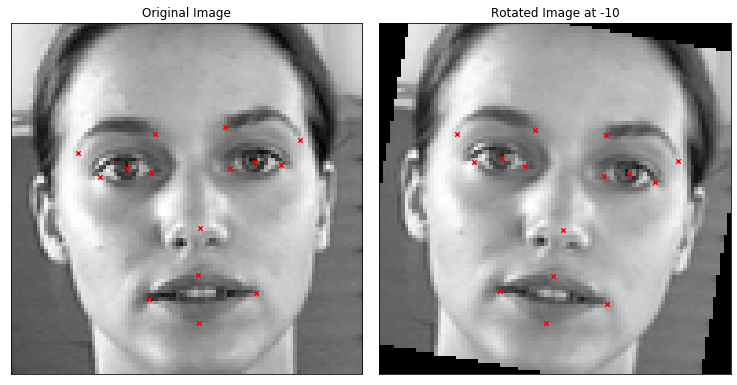

In [112]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_training[image_index].reshape(96,96),cmap='gray')
ax.scatter(Y_training[image_index, range(0, 30, 2)], Y_training[image_index, range(1, 30, 2)], \
           marker = 'x', s=20, color='r')

# Plot the rotated image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
if image_index%2 ==0:
    degree_dir = '+' + str(degree)
else:
    degree_dir = '-' + str(degree)
    
ax.set_title('Rotated Image at '+ degree_dir)
ax.imshow(X_train_rotate[image_index].reshape(96,96),cmap='gray')
ax.scatter(Y_train_rotate[image_index, range(0, 30, 2)], Y_train_rotate[image_index, range(1, 30, 2)], \
           marker = 'x', s=20, color='r')



### 3. Histogram Equalization

This method increases the global contrast of most images mainly when the pixels in image represent close contrast values. It allows the intensities to be better distributed on histogram. It allows lower local contrast to gain a higher contrast. This transformation is explored as the training images show varying modes of contrast, brightness etc. By augmenting the existing trimmed train dataset with such transformations could further help improve the training and make better predictions.

https://medium.com/@animeshsk3/back-to-basics-part-1-histogram-equalization-in-image-processing-f607f33c5d55

https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist


In [113]:
# This function uses equalize_hist function under exposure module of skimage.
# Only the images are transformed, the keypoints will be same.
def histogram_eq(images, flag):
    
    # Apply Histogram Equalization to an image
    def image_histogram_eq(image):
        orig_image = image.reshape(96, 96)
        hist_eq_image = exposure.equalize_hist(orig_image)
    
        return hist_eq_image
    
    images_eq = images.copy()
    for index in range(0, len(images)):
        if flag == True:
            images_eq[index] = image_histogram_eq(images[index]).reshape(96, 96, 1)
        else:
            images_eq[index] = image_histogram_eq(images[index]).reshape(-1, (96*96)) 
        
    return images_eq

In [114]:
# Call function to apply histogram equalization to train data images
X_train_hist_eq = histogram_eq(X_training, True)

In [20]:
X_train_hist_eq.shape

(2138, 96, 96, 1)

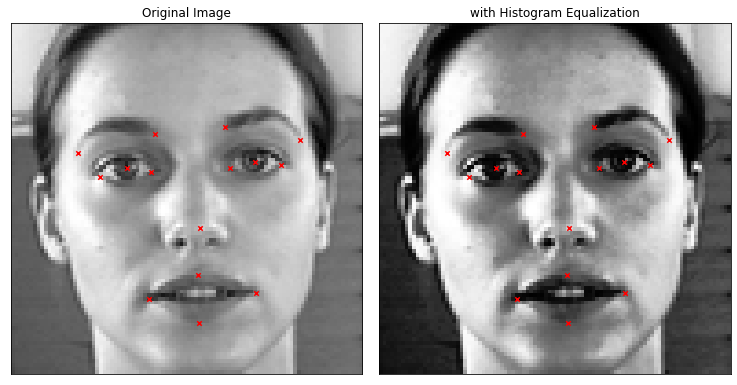

In [115]:
# Set the plot dimensions
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_training[image_index].reshape(96,96),cmap='gray')
ax.scatter(Y_training[image_index, range(0, 30, 2)], Y_training[image_index, range(1, 30, 2)], \
           marker = 'x', s=20, color='r')

# Plot the transformed image with train labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Histogram Equalization')
ax.imshow(X_train_hist_eq[image_index].reshape(96,96),cmap='gray')
ax.scatter(Y_training[image_index, range(0, 30, 2)], Y_training[image_index, range(1, 30, 2)], \
           marker = 'x', s=20, color='r')
    
plt.show()

### 4. Blurring


Another transformation done only to the pixel values in images to introduce random noise by using the scipy's gaussian_filter.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html

As many images in train data are not high resolution images, there is a lot of noise like blurring. This transformation will help to augment existing train data with such data. 

In [116]:
# Apply Blurring using Gaussian Filter to the train data images with sigma = 1.
# The keypoints are not transformed.
def gaussion_blur(images):
    
    images_blur = images.copy()
    
    for index in range(0, len(images)):
        images_blur[index] = gaussian_filter(images[index], sigma = 1).reshape(96, 96, 1)
        
    return images_blur

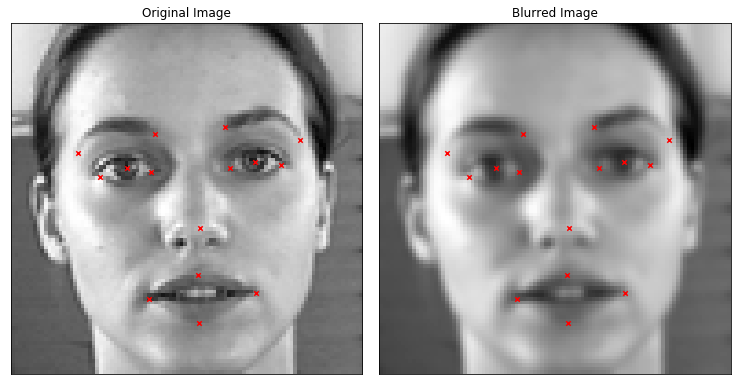

In [117]:
# Call function to apply gaussian blur filter to train images
X_train_blur = gaussion_blur(X_training)
        
# Make a copy of the training dataset to apply transformation
#X_blur = X_train.copy()
    
# Apply Gaussian Blur to all the training data images
#for index in range(0, len(X_train)):
#    X_blur[index] = gaussian_filter(X_blur[index], sigma = 1).reshape(96, 96, 1)
        
# Set the plot dimensions
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
        
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_training[image_index].reshape(96,96),cmap='gray')
ax.scatter(Y_training[image_index, range(0, 30, 2)], Y_training[image_index, range(1, 30, 2)], \
             marker = 'x', s=20, color='r')

# Plot the transformed image with train labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('Blurred Image')
ax.imshow(X_train_blur[image_index].reshape(96,96),cmap='gray')
ax.scatter(Y_training[image_index, range(0, 30, 2)], Y_training[image_index, range(1, 30, 2)], \
        marker = 'x', s=20, color='r')

### Defining the Datasets for Modeling

Based on the analysis of the given Kaggle training dataset done in the Baseline submission of the project, we found that out of the 30 keypoint labels, only 8 keypoints had data for more than 7000 images. 
The remaining 22 keypoint labels are present for only less than 3000 images. 
This demarcation in the labeling inconsistensies lead us to defining our modeling dataset(s) with the following approches:

- <b>Approach #1</b>
    * First dataset will comprise of all the 8 keypoints present for 7000+ images. We will have one model trained on this dataset.
    * Second dataset will comprise of the remaining 22 keypoints present for less than 3000 images. Have a second model trained on this dataset. 
    * Do prediction on the Kaggle Test Data on both models. Combine the 2 sets of predictions to determine overall performance.

- <b>Approach #2</b>
    * First dataset will comprise of all the 8 keypoints present for 7000+ images. We will have one model trained on this dataset.
    * Second dataset will comprise of the 30 keypoints present for around 2000 images. Have a second model trained on this dataset. 
    * Do prediction on the Kaggle Test Dataon both models. From the prediction from second model, replace predictions of the for the 8 keypoints(used in first model) with the corresponding predictions from first model. 
    
We feel either approach would not result in a much difference, so we decided to go with Approach #1.

Next we will define the 2 datasets and use these for testing data augmentation techniques with a simple model.

In [118]:
# train_data_orig will have the kaggle data. Not preprocessed.
# Will use this to define our datasets.
train_data_orig = train.copy()

In [119]:
# Check count of missing data for all 15 facial keypoints
train_data_orig.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

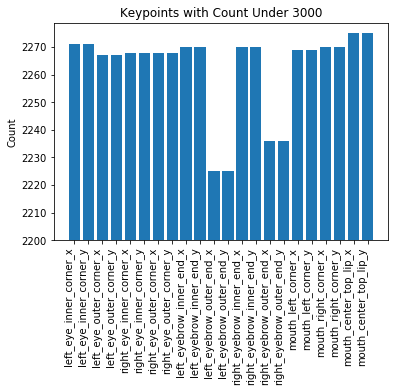

In [23]:
# keypoints with less than 3000 labels
kp = train_data_orig.describe()
less_kp = kp.loc[:, kp.loc['count'] < 3000].loc['count']
more_kp = kp.loc[:, kp.loc['count'] > 3000].loc['count']
_l = np.arange(len(less_kp))
_m = np.arange(len(more_kp))

fig, ax1 = plt.subplots()
ax1.bar(_l, less_kp-2200, bottom=2200)
ax1.set_ylabel('Count')
ax1.set_xticks(_l)
ax1.set_xticklabels(less_kp.index, rotation=90, ha='right')
ax1.set_title("Keypoints with Count Under 3000")
plt.show()

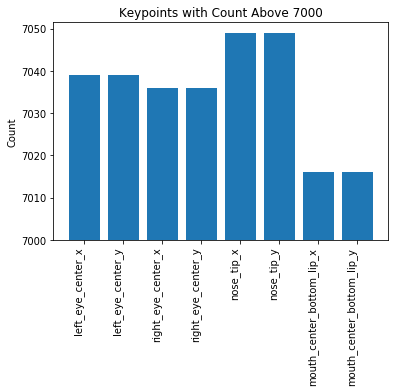

In [24]:
# Keypoints with more than 7000 labels
fig, ax2 = plt.subplots()
ax2.bar(_m, more_kp-7000, bottom=7000)
ax2.set_xticks(_m)
ax2.set_xticklabels(more_kp.index, rotation=90, ha='right')
ax2.set_ylabel('Count')
ax2.set_title("Keypoints with Count Above 7000")
plt.show()

In [25]:
# List the train data columns with corresponding indices in the dataset
for col in range(len(train_data_orig.columns)):
    print (col, train_data_orig.columns[col])

0 left_eye_center_x
1 left_eye_center_y
2 right_eye_center_x
3 right_eye_center_y
4 left_eye_inner_corner_x
5 left_eye_inner_corner_y
6 left_eye_outer_corner_x
7 left_eye_outer_corner_y
8 right_eye_inner_corner_x
9 right_eye_inner_corner_y
10 right_eye_outer_corner_x
11 right_eye_outer_corner_y
12 left_eyebrow_inner_end_x
13 left_eyebrow_inner_end_y
14 left_eyebrow_outer_end_x
15 left_eyebrow_outer_end_y
16 right_eyebrow_inner_end_x
17 right_eyebrow_inner_end_y
18 right_eyebrow_outer_end_x
19 right_eyebrow_outer_end_y
20 nose_tip_x
21 nose_tip_y
22 mouth_left_corner_x
23 mouth_left_corner_y
24 mouth_right_corner_x
25 mouth_right_corner_y
26 mouth_center_top_lip_x
27 mouth_center_top_lip_y
28 mouth_center_bottom_lip_x
29 mouth_center_bottom_lip_y
30 Image


#### Dataset #1
* left_eye_center
* right_eye_center
* node_tip
* mouth_center_bottom_lip

We will have 7000 images with 8 keypoint labels as shown below after trimming out missing data.

In [120]:
# Define the label indices for Dataset #1
d1_label_indices = [0, 1, 2, 3, 20, 21, 28, 29]
d1 = train_data_orig.iloc[:, d1_label_indices]
print(d1.shape)

# trim any missing data
d1_trim = d1[~np.isnan(d1).any(axis = 1)]
print("After trimming missing data: {}".format(d1_trim.shape))

(7049, 8)
After trimming missing data: (7000, 8)


#### Dataset #2
* left_eye_inner_corner
* left_eye_outer_corner
* right_eye_inner_corner
* right_eye_outer_corner
* left_eyebrow_inner_end
* left_eyebrow_outer_end
* right_eyebrow_inner_end
* right_eyebrow_outer_end
* mouth_left_corner
* mouth_right_corner
* mouth_center_top_lip

We will have 2155 images with 22 keypoint labels as shown below after trimming out missing data.

In [121]:
d2_label_indices = list(range(4, 20)) + list(range(22, 28))
d2 = train_data_orig.iloc[:, d2_label_indices]
print(d2.shape)

# trim any missing values
d2_trim = d2[~np.isnan(d2).any(axis = 1)]
print("After trimming missing data: {}".format(d2_trim.shape))


(7049, 22)
After trimming missing data: (2155, 22)


#### Define Master Dataset

This set will not have any rows with missing values removed. It will use the entire 7049 images and keypoints co-ordinates.

In [122]:
# Now split the Kaggle training dataset into input images and keypoints labels

# First shuffle the Kaggle training data
np.random.seed(533)
shuffle = np.random.permutation(np.arange(train_data_orig.shape[0]))
train_shuff = train_data_orig.iloc[shuffle].reset_index(drop=True)

print("Loading data...")
# Split out image values
images = []
for i in range(train_shuff.shape[0]):
    img = train_shuff['Image'][i].split(' ')
    img = ['0' if j == '' else j for j in img]
    images.append(img) 

# Assign to np array
X_train_master = np.array(images, dtype = 'float64')
print(X_train_master.shape)

# Get the keypoint labels
labels = train_shuff.drop('Image', axis = 1)
Y_train_master = np.array(labels, dtype = 'float64')
print(Y_train_master.shape)

Loading data...
(7049, 9216)
(7049, 30)


In [41]:
## FLoydHub
df = train_data_orig.copy()
df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

# Scale the pixel values to be between 0, 1
X_train_master = np.vstack(df['Image'].values) / 255.
X_train_master = X_train_master.astype(np.float32)

Y_train_master = df[df.columns[:-1]].values   

#X_train_master, Y_train_master = shuffle(X_train_master, Y_train_master, random_state=42)
Y_train_master = Y_train_master.astype(np.float32)
print(X_train_master.shape)
print(Y_train_master.shape)

(7049, 9216)
(7049, 30)


In [46]:
# Also save these arrays to use in other notebooks and across users
np.save('X_train_master.npy', X_train_master)
np.save('Y_train_master.npy', Y_train_master)

In [98]:
# Load from saved arrays
X_train_orig = np.load('X_train_master.npy')
Y_train_orig = np.load('Y_train_master.npy')
print(X_train_orig.shape, Y_train_orig.shape)

In [123]:
# Make a copy so as not to change the master
X_train_orig = np.copy(X_train_master)
Y_train_orig = np.copy(Y_train_master)
print(X_train_orig.shape, Y_train_orig.shape)

(7049, 9216) (7049, 30)


In [124]:
# Normalize the pixel values to be between (0, 1)
X_train_orig = X_train_orig/255.
print(X_train_orig.shape, Y_train_orig.shape)

(7049, 9216) (7049, 30)


In [126]:
# Split into train and test features(images) with 99:1 split
# X_test will be used for testing predictions
# X_train will be split into train and validation tests while training the models
X_train, X_test = np.copy(X_train_orig[:6978]), np.copy(X_train_orig[6978:])
print(X_train.shape, X_test.shape)

# create training and test labels 99:1 split
Y_train, Y_test = np.copy(Y_train_orig[:6978]), np.copy(Y_train_orig[6978:])
print(Y_train.shape, Y_test.shape)

(6978, 9216) (71, 9216)
(6978, 30) (71, 30)


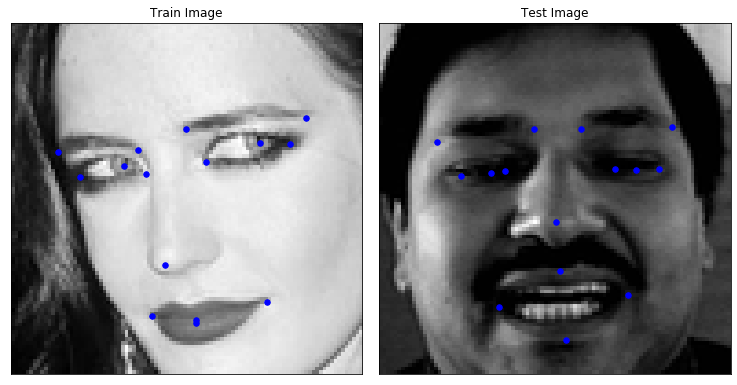

In [130]:
# Set the plot dimensions
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 12
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Train Image')
ax.imshow(X_train[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train[aug_img_idx, range(0, 30, 2)], Y_train[aug_img_idx, range(1, 30, 2)], marker = 'o', s=30, color='b')
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('Test Image')
ax.imshow(X_test[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_test[aug_img_idx, range(0, 30, 2)], Y_test[aug_img_idx, range(1, 30, 2)], marker = 'o', s=30, color='b')

#### Dataset 1: 8 keypoints

We will have 7000 samples in this dataset split into train and validation datasets.

**** Use this ****

In [132]:
# Dataset 1

# Filter the split dataset based on labels for only 8 keypoints as defined above
keypoints = [0, 1, 2, 3, 20, 21, 28, 29]
Y_train_d1 = np.copy(Y_train[:, keypoints])

# Remove missing labels from train
# Get list of non-missing labels
index_list_tr = ~np.isnan(Y_train_d1).any(axis=1)

# Now define the final input images and keypoint labels for train dataset for Dataset 1
X_train_d1 = np.copy(X_train[index_list_tr])
Y_train_d1 = Y_train_d1[index_list_tr]

print("-- Size of train dataset for Dataset 1 --")
print("Train:" + str(X_train_d1.shape) + str(Y_train_d1.shape))


-- Size of train dataset for Dataset 1 --
Train:(6929, 9216)(6929, 8)


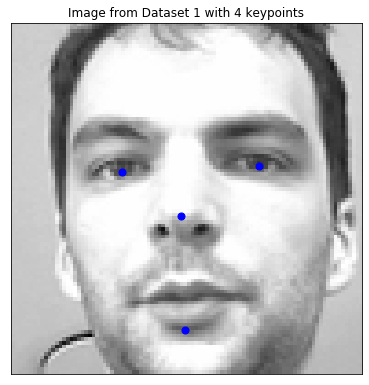

In [133]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 14
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Image from Dataset 1 with 4 keypoints')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'o', s=50, color='b')

#### Dataset 2: 22 keypoints

We will have 2155 samples in this dataset split into train and validation datasets.

In [134]:
# Dataset 2

# Filter the master dataset based on labels for only 22 keypoints as defined above
keypoints2 = list(range(4, 20)) + list(range(22, 28))
Y_train_d2 = np.copy(Y_train[:, keypoints2])

# Remove missing labels
# Get list of non-missing labels
index_list_tr = ~np.isnan(Y_train_d2).any(axis=1)

# Now define the final input images and keypoint labels for Dataset1
X_train_d2 = np.copy(X_train[index_list_tr])
Y_train_d2 = Y_train_d2[index_list_tr]

print("-- Size of train dataset for Dataset 2 --")
print("Train:" + str(X_train_d2.shape) + str(Y_train_d2.shape))


-- Size of train dataset for Dataset 2 --
Train:(2134, 9216)(2134, 22)


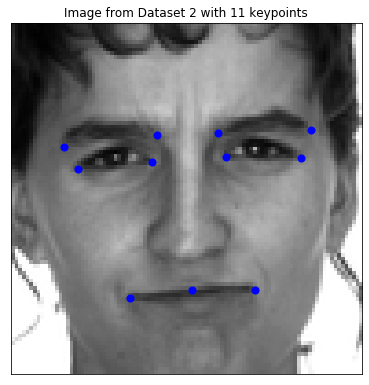

In [135]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 14
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Image from Dataset 2 with 11 keypoints')
ax.imshow(X_train_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2[aug_img_idx, range(0, 22, 2)], Y_train_d2[aug_img_idx, range(1, 22, 2)], marker = 'o', s=50, color='b')

#### Apply data transformation techniques to train data on both datasets d1 and d2

###### 1. Horizontal Flipping 

In [136]:
# Horizontal Flip(Mirror)
X_train_flip_d1 = np.zeros((X_train_d1.shape), dtype = np.float32)
X_train_flip_d1 = flip_images(X_train_d1)

Y_train_flip_d1 = np.zeros((Y_train_d1.shape), dtype = np.float32)
Y_train_flip_d1 = flip_keypoints(Y_train_d1, 8)
print("Train d1 with flipping: {} {}".format(X_train_flip_d1.shape, Y_train_flip_d1.shape))


Train d1 with flipping: (6929, 9216) (6929, 8)


In [137]:
# Horizontal Flip(Mirror)
X_train_flip_d2 = np.zeros((X_train_d2.shape), dtype = np.float32)
X_train_flip_d2 = flip_images(X_train_d2)

Y_train_flip_d2 = np.zeros((Y_train_d2.shape), dtype = np.float32)
Y_train_flip_d2 = flip_keypoints(Y_train_d2, 22)
print("Train d2 with flipping: {} {}".format(X_train_flip_d2.shape, Y_train_flip_d2.shape))


Train d2 with flipping: (2134, 9216) (2134, 22)


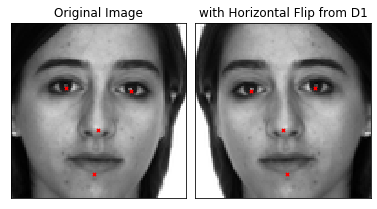

In [138]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 687
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Horizontal Flip from D1')
ax.imshow(X_train_flip_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_flip_d1[aug_img_idx, range(0, 8, 2)], Y_train_flip_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', \
           s=10, color='r')

plt.show()

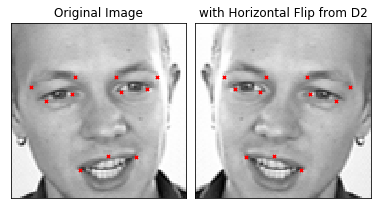

In [139]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 687
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2[aug_img_idx, range(0,22, 2)], Y_train_d2[aug_img_idx, range(1, 22, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Horizontal Flip from D2')
ax.imshow(X_train_flip_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_flip_d2[aug_img_idx, range(0, 22, 2)], Y_train_flip_d2[aug_img_idx, range(1, 22, 2)], marker = 'x', \
           s=10, color='r')

plt.show()

##### 2. Rotation at 5 degrees

In [140]:
degree = 5
# Augment train data for dataset 1 with rotation of its images and keypoints
X_train_d1_rotate_5 = rotate_images(X_train_d1.reshape(len(X_train_d1), 96, 96, 1), degree, True)
Y_train_d1_rotate_5 = rotate_keypoints(Y_train_d1, degree, 8)

print("Train d1 with rotation: {} {}".format(X_train_d1_rotate_5.shape, Y_train_d1_rotate_5.shape))

Train d1 with rotation: (6929, 96, 96, 1) (6929, 8)


In [141]:
X_train_d2_rotate_5 = rotate_images(X_train_d2.reshape(len(X_train_d2), 96, 96, 1), 5, True)
Y_train_d2_rotate_5 = rotate_keypoints(Y_train_d2, 5, 22)

#print("Train d1 with rotation: {} {}".format(X_train_d1_rotate_5.shape, Y_train_d1_rotate_5.shape))
#print(X_train_d2_rotate_5.shape)

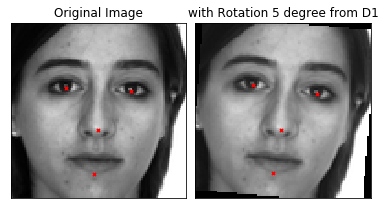

In [142]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 687
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Rotation 5 degree from D1')
ax.imshow(X_train_d1_rotate_5[aug_img_idx].reshape(96, 96),cmap='gray')
ax.scatter(Y_train_d1_rotate_5[aug_img_idx, range(0, 8, 2)], Y_train_d1_rotate_5[aug_img_idx, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

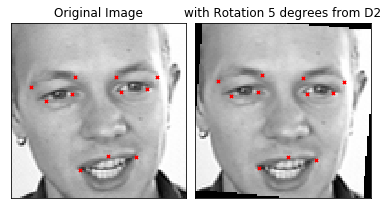

In [57]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 687
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2[aug_img_idx, range(0, 22, 2)], Y_train_d2[aug_img_idx, range(1, 22, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Rotation 5 degrees from D2')
ax.imshow(X_train_d2_rotate_5[aug_img_idx].reshape(96, 96),cmap='gray')
ax.scatter(Y_train_d2_rotate_5[aug_img_idx, range(0, 22, 2)], Y_train_d2_rotate_5[aug_img_idx, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')

##### 3. Rotation at 10 degrees

In [143]:
degree = 10
# Augment train data for dataset 1 with rotation of its images and keypoints
X_train_d1_rotate_10 = rotate_images(X_train_d1.reshape(len(X_train_d1), 96, 96, 1), degree, True)
Y_train_d1_rotate_10 = rotate_keypoints(Y_train_d1, degree, 8)

print("Train d1 with rotation: {} {}".format(X_train_d1_rotate_10.shape, Y_train_d1_rotate_10.shape))

Train d1 with rotation: (6929, 96, 96, 1) (6929, 8)


In [144]:
X_train_d2_rotate_10 = rotate_images(X_train_d2.reshape(len(X_train_d2), 96, 96, 1), degree, True)
Y_train_d2_rotate_10 = rotate_keypoints(Y_train_d2, degree, 22)

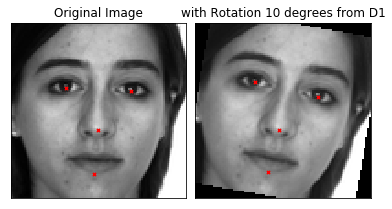

In [145]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 687
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Rotation 10 degrees from D1')
ax.imshow(X_train_d1_rotate_10[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_rotate_10[aug_img_idx, range(0, 8, 2)], Y_train_d1_rotate_10[aug_img_idx, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

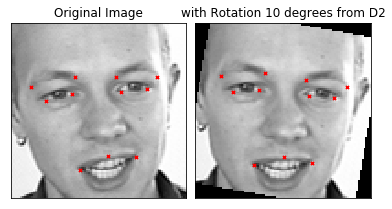

In [146]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 687
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2[aug_img_idx, range(0, 22, 2)], Y_train_d2[aug_img_idx, range(1, 22, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Rotation 10 degrees from D2')
ax.imshow(X_train_d2_rotate_10[aug_img_idx].reshape(96, 96),cmap='gray')
ax.scatter(Y_train_d2_rotate_10[aug_img_idx, range(0, 22, 2)], Y_train_d2_rotate_10[aug_img_idx, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')

##### 4. Rotation at 15 degrees

In [147]:
degree = 15
# Augment train data for dataset 1 with rotation of its images and keypoints
X_train_d1_rotate_15 = rotate_images(X_train_d1.reshape(len(X_train_d1), 96, 96, 1), degree, True)
Y_train_d1_rotate_15 = rotate_keypoints(Y_train_d1, degree, 8)

print("Train d1 with rotation: {} {}".format(X_train_d1_rotate_15.shape, Y_train_d1_rotate_15.shape))

Train d1 with rotation: (6929, 96, 96, 1) (6929, 8)


In [148]:
# Augment train data for dataset 1 with rotation of its images and keypoints
X_train_d2_rotate_15 = rotate_images(X_train_d2.reshape(len(X_train_d2), 96, 96, 1), degree, True)
Y_train_d2_rotate_15 = rotate_keypoints(Y_train_d2, degree, 22)

print("Train d1 with rotation: {} {}".format(X_train_d2_rotate_15.shape, Y_train_d2_rotate_15.shape))

Train d1 with rotation: (2134, 96, 96, 1) (2134, 22)


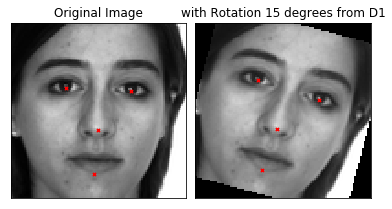

In [149]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 687
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Rotation 15 degrees from D1')
ax.imshow(X_train_d1_rotate_15[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_rotate_15[aug_img_idx, range(0, 8, 2)], Y_train_d1_rotate_15[aug_img_idx, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

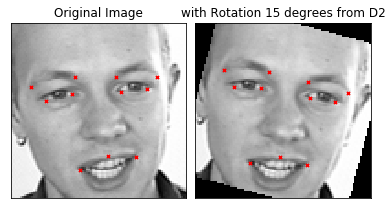

In [150]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 687
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2[aug_img_idx, range(0, 22, 2)], Y_train_d2[aug_img_idx, range(1, 22, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Rotation 15 degrees from D2')
ax.imshow(X_train_d2_rotate_15[aug_img_idx].reshape(96, 96),cmap='gray')
ax.scatter(Y_train_d2_rotate_15[aug_img_idx, range(0, 22, 2)], Y_train_d2_rotate_15[aug_img_idx, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')

##### 5. Histogram Equalization

In [151]:
# Augment train data for dataset 1 with histogram equalization of image pixels
X_train_d1_hist_eq = histogram_eq(X_train_d1.reshape(-1, 96*96), False)
Y_train_d1_hist_eq = Y_train_d1.copy()

print(X_train_d1_hist_eq.shape)

(6929, 9216)


In [152]:
# Augment train data for dataset 1 with histogram equalization of image pixels
X_train_d2_hist_eq = histogram_eq(X_train_d2.reshape(-1, 96*96), False)
Y_train_d2_hist_eq = Y_train_d2.copy()

print(X_train_d2_hist_eq.shape)

(2134, 9216)


In [87]:
# Also save these arrays to use in other notebooks and across users
np.save('X_train_d1_hist_eq.npy', X_train_d1_hist_eq)
np.save('Y_train_d1_hist_eq.npy', Y_train_d1_hist_eq)

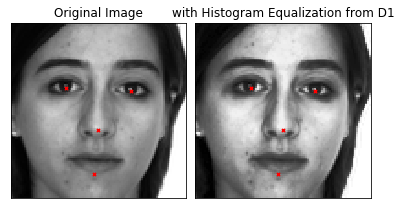

In [153]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 687
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Histogram Equalization from D1')
ax.imshow(X_train_d1_hist_eq[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_hist_eq[aug_img_idx, range(0, 8, 2)], Y_train_d1_hist_eq[aug_img_idx, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

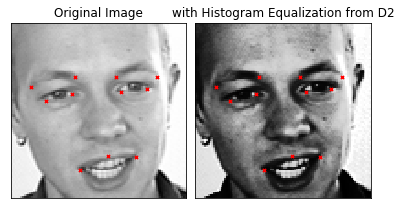

In [154]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 687
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2[aug_img_idx, range(0, 22, 2)], Y_train_d2[aug_img_idx, range(1, 22, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Histogram Equalization from D2')
ax.imshow(X_train_d2_hist_eq[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2_hist_eq[aug_img_idx, range(0, 22, 2)], Y_train_d2_hist_eq[aug_img_idx, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

##### 6. Gaussian Blurring


In [155]:
# Augment train data for dataset 1 with gaussian blurring of image pixels
X_train_d1_blur = gaussion_blur(X_train_d1.reshape(-1, 96, 96, 1))
Y_train_d1_blur = Y_train_d1.copy()

In [156]:
# Augment train data for dataset 1 with gaussian blurring of image pixels
X_train_d2_blur = gaussion_blur(X_train_d2.reshape(-1, 96, 96, 1))
Y_train_d2_blur = Y_train_d2.copy()

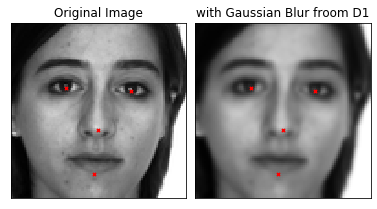

In [157]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 687
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Gaussian Blur froom D1')
ax.imshow(X_train_d1_blur[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_blur[aug_img_idx, range(0, 8, 2)], Y_train_d1_blur[aug_img_idx, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

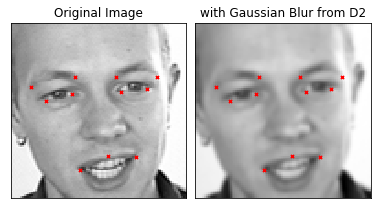

In [158]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 687
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2[aug_img_idx, range(0, 22, 2)], Y_train_d2[aug_img_idx, range(1, 22, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Gaussian Blur from D2')
ax.imshow(X_train_d2_blur[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2_blur[aug_img_idx, range(0, 22, 2)], Y_train_d2_blur[aug_img_idx, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

## Data Augmentation

Here we will use the transformed datasets to augment existing train datasets for d1 and d2.
We will create a simple CNN Model to do the training of the augmented train data and evaluate performance.

### Define a Simple CNN 

This will be used for testing different augmentation techniques.

The architecture uses a 3 convolutional layers with 8/4/2 filter weights with relu activation. Batch Normalization is introduced after each layer as a regularization technique to help coordinate the update of multiple layers in the model. This will help with stability of the model as it normalizes the output from previous activation layer by subtracting the batch mean and dividing by the batch std. deviation. T 

All models are trained with batch size of 50 using 'adam' optimizer. The number of epochs are set to 50 but EarlyStopping https://keras.io/callbacks/ callback on validation loss is used to stop training when val. loss doesn't improve.   

In [159]:
def Simple_CNN_Aug(points):
    
    model = Sequential()
    
    model.add(Conv2D(8, (5, 5), strides = (1,1), activation = 'relu', padding = 'same', \
              input_shape = (96, 96, 1), data_format='channels_last'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides= (1,1)))
    
    model.add(Conv2D(4, (3, 3), strides = (1,1), activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides= (1,1)))
    
    model.add(Conv2D(2, (3, 3), strides = (1,1), activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides= (1,1)))
              
    model.add(Flatten())
    model.add(Dense(100, activation = 'linear'))
    #model.add(Dropout(0.5))
    model.add(Dense(points))

    return model

In [160]:
# Helper function to find RMSE(Root Mean Squared Error)
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# The early stop callback will terminate a training session if no progress is being made
#early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=15, mode='auto')
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Reduce learning Rate on Plateau to reduce the learning rate once learning stagnates. 
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=10, factor= .4, min_lr=.00001)

#### 1. No Augmentation

In [161]:
# Split image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_1s_t_d1, X_1s_v_d1, Y_1s_t_d1, Y_1s_v_d1 = train_test_split(X_train_d1, Y_train_d1, test_size=0.2, random_state=42, shuffle=True)

print("Train: {} {}".format(X_1s_t_d1.shape, Y_1s_t_d1.shape))
print("Val: {} {}".format(X_1s_v_d1.shape, Y_1s_v_d1.shape))
      

Train: (5543, 9216) (5543, 8)
Val: (1386, 9216) (1386, 8)


In [258]:
# Create model 1 from Simple CNN with 8 outputs using d1
m1s_d1 = Simple_CNN_Aug(8)
m1s_d1.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'accuracy'])

# Train the model using train and validation data from Dataset 1
%time history_m1s_d1 = m1s_d1.fit(X_1s_t_d1.reshape(-1, 96, 96, 1), Y_1s_t_d1, epochs=50, \
                                         shuffle=False, batch_size=50, validation_split = 0, \
                                         validation_data = (X_1s_v_d1.reshape(-1, 96, 96, 1), Y_1s_v_d1), \
                                         callbacks=[early_stop], verbose=2)

Train on 5543 samples, validate on 1386 samples
Epoch 1/50
 - 6s - loss: 242.9006 - rmse: 13.4626 - accuracy: 0.8153 - val_loss: 1887.0329 - val_rmse: 43.4347 - val_accuracy: 0.9899
Epoch 2/50
 - 6s - loss: 38.2349 - rmse: 6.0018 - accuracy: 0.9625 - val_loss: 1212.1480 - val_rmse: 34.8090 - val_accuracy: 0.9899
Epoch 3/50
 - 6s - loss: 22.8500 - rmse: 4.7299 - accuracy: 0.9780 - val_loss: 1008.1954 - val_rmse: 31.7414 - val_accuracy: 0.9892
Epoch 4/50
 - 6s - loss: 18.5514 - rmse: 4.2629 - accuracy: 0.9827 - val_loss: 606.6344 - val_rmse: 24.6133 - val_accuracy: 0.9863
Epoch 5/50
 - 6s - loss: 17.5067 - rmse: 4.1385 - accuracy: 0.9829 - val_loss: 298.9775 - val_rmse: 17.2654 - val_accuracy: 0.9848
Epoch 6/50
 - 6s - loss: 17.1201 - rmse: 4.0853 - accuracy: 0.9832 - val_loss: 100.0776 - val_rmse: 9.9564 - val_accuracy: 0.9798
Epoch 7/50
 - 6s - loss: 18.9479 - rmse: 4.2793 - accuracy: 0.9773 - val_loss: 45.6169 - val_rmse: 6.6553 - val_accuracy: 0.9827
Epoch 8/50
 - 6s - loss: 19.2373 

In [ ]:
m1s_d1.save('model1_no_aug_d1.h5')

In [164]:
simple_models_history_pd  = pd.DataFrame()
hist = pd.DataFrame(history_m1s_d1.history)
hist['Model_Name'] = 'Model1 d1: No Aug.'
hist['Model_Code'] = 'm1s_d1'
hist['Val_RMSE'] = min(hist.val_rmse)
hist['RMSE'] = min(hist.rmse)
simple_models_history_pd = pd.concat([simple_models_history_pd, hist])


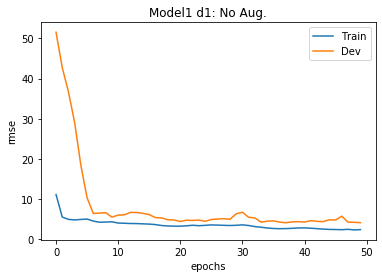

Val RMSE: 4.07313871383667
Train RMSE: 2.2836928367614746 
Val Accuracy: 0.9914101362228394
Train Accuracy: 0.9939318299293518 


In [168]:
plot_metrics('Model1 d1: No Aug.', history_m1s_d1)

In [165]:
# Split image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_1s_t_d2, X_1s_v_d2, Y_1s_t_d2, Y_1s_v_d2 = train_test_split(X_train_d2, Y_train_d2, test_size=0.2, random_state=42, shuffle=True)

print("Train: {} {}".format(X_1s_t_d2.shape, Y_1s_t_d2.shape))
print("Val: {} {}".format(X_1s_v_d2.shape, Y_1s_v_d2.shape))

Train: (1707, 9216) (1707, 22)
Val: (427, 9216) (427, 22)


In [167]:
# Create model 1 from Simple CNN with 22 outputs using d2
m1s_d2 = Simple_CNN_Aug(22)
m1s_d2.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'accuracy'])

# Train the model using train and validation data from Dataset2
%time history_m1s_d2 = m1s_d2.fit(X_1s_t_d2.reshape(-1, 96, 96, 1), Y_1s_t_d2, epochs=50, \
                                         shuffle=False, batch_size=50, validation_split = 0, \
                                          validation_data = (X_1s_v_d2.reshape(-1, 96, 96, 1), Y_1s_v_d2), \
                                         callbacks=[early_stop], verbose=2)

Train on 1707 samples, validate on 427 samples
Epoch 1/50
 - 3s - loss: 342.3813 - rmse: 15.9524 - accuracy: 0.2800 - val_loss: 2617.5911 - val_rmse: 51.1450 - val_accuracy: 0.0094
Epoch 2/50
 - 2s - loss: 38.9810 - rmse: 6.1189 - accuracy: 0.6421 - val_loss: 2685.8823 - val_rmse: 51.8080 - val_accuracy: 0.0023
Epoch 3/50
 - 2s - loss: 20.5830 - rmse: 4.4361 - accuracy: 0.7200 - val_loss: 2651.5318 - val_rmse: 51.4767 - val_accuracy: 0.0047
Epoch 4/50
 - 2s - loss: 15.1345 - rmse: 3.8168 - accuracy: 0.7452 - val_loss: 2593.8676 - val_rmse: 50.9158 - val_accuracy: 0.0351
Epoch 5/50
 - 2s - loss: 16.6164 - rmse: 4.0277 - accuracy: 0.7071 - val_loss: 2495.1064 - val_rmse: 49.9409 - val_accuracy: 0.1616
Epoch 6/50
 - 2s - loss: 40.1971 - rmse: 6.2706 - accuracy: 0.4792 - val_loss: 2402.0243 - val_rmse: 49.0090 - val_accuracy: 0.0796
Epoch 7/50
 - 2s - loss: 61.7254 - rmse: 7.7062 - accuracy: 0.4230 - val_loss: 2262.1788 - val_rmse: 47.5542 - val_accuracy: 0.2670
Epoch 8/50
 - 2s - loss: 28

In [169]:
#simple_models_history_pd  = pd.DataFrame(history_m1s_d1)
hist = pd.DataFrame(history_m1s_d2.history)
hist['Model_Name'] = 'Model1 d2: No Aug.'
hist['Model_Code'] = 'm1s_d2'
hist['Val_RMSE'] = min(hist.val_rmse)
hist['RMSE'] = min(hist.rmse)
simple_models_history_pd = pd.concat([simple_models_history_pd, hist])

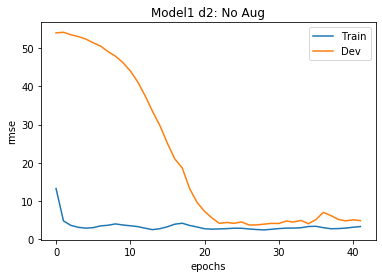

Val RMSE: 3.7753989696502686
Train RMSE: 2.496464967727661 
Val Accuracy: 0.8005114793777466
Train Accuracy: 0.7681406140327454 


In [64]:
plot_metrics('Model1 d2: No Aug', history_m1s_d2)

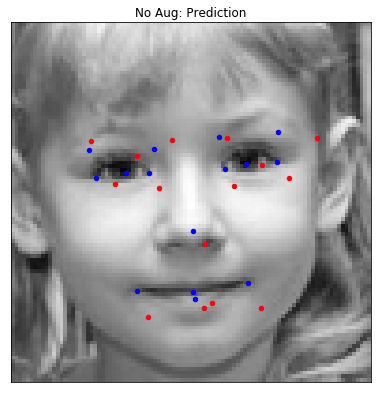

In [215]:
# Predict on Test image
y_d1 = m1s_d1.predict(X_test[29].reshape(-1, 96, 96, 1))
y_d2 = m1s_d2.predict(X_test[29].reshape(-1, 96, 96, 1))

# Combine both results
y_comb = np.zeros((1, 30), dtype = np.float32)
y_comb[:, d1_label_indices] = y_d1
y_comb[:, d2_label_indices] = y_d2

# Plot
idx = 29
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
img = X_test[idx].reshape(96, 96)
ax.set_title('No Aug: Prediction')
ax.imshow(img, cmap='gray')
ax.scatter(Y_test[idx][range(0,30,2)], Y_test[idx][range(1,30,2)], marker='o', s = 20, color='b')
ax.scatter(y_comb[0][range(0,30,2)], y_comb[0][range(1,30,2)], marker='o', s = 20, color='r')
plt.show()

#### 2. With Horizontal Flipping(Mirroring)

In [177]:
# Augment train data for dataset 1 with horizontal flipping of its images and keypoints 
X_train_d1_flip_comb = np.concatenate((X_train_d1, X_train_flip_d1), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d1_flip_comb = np.concatenate((Y_train_d1, Y_train_flip_d1), axis = 0)
print("Train d1 with flipping: {} {}".format(X_train_d1_flip_comb.shape, Y_train_d1_flip_comb.shape))


Train d1 with flipping: (13858, 96, 96, 1) (13858, 8)


In [178]:
# Augment train data for dataset 2 with horizontal flipping of its images and keypoints 
X_train_d2_flip_comb = np.concatenate((X_train_d2, X_train_flip_d2), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d2_flip_comb = np.concatenate((Y_train_d2, Y_train_flip_d2), axis = 0)
print("Train d2 with flipping: {} {}".format(X_train_d2_flip_comb.shape, Y_train_d2_flip_comb.shape))


Train d2 with flipping: (4268, 96, 96, 1) (4268, 22)


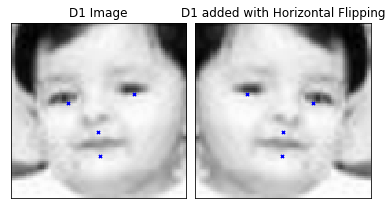

In [185]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 0
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('D1 Image')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='b')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('D1 added with Horizontal Flipping')
ax.imshow(X_train_d1_flip_comb[6929].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_flip_comb[6929, range(0, 8, 2)], Y_train_d1_flip_comb[6929, range(1, 8, 2)], \
           marker = 'x', s=10, color='b')

plt.show()

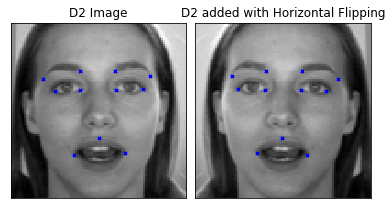

In [186]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 1
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('D2 Image')
ax.imshow(X_train_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2[aug_img_idx, range(0, 22, 2)], Y_train_d2[aug_img_idx, range(1, 22, 2)], marker = 'x', s=10, color='b')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('D2 added with Horizontal Flipping')
ax.imshow(X_train_d2_flip_comb[2135].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2_flip_comb[2135, range(0, 22, 2)], Y_train_d2_flip_comb[2135, range(1, 22, 2)], \
           marker = 'x', s=10, color='b')

plt.show()

In [190]:
# Split image examples and facial keypoints labels into train and validation datasets using 80:20 split for d1
X_2s_t_d1, X_2s_v_d1, Y_2s_t_d1, Y_2s_v_d1 = train_test_split(X_train_d1_flip_comb, Y_train_d1_flip_comb, \
                                                              test_size=0.2, random_state=42, shuffle=True)

print("Train: {} {}".format(X_2s_t_d1.shape, Y_2s_t_d1.shape))
print("Val: {} {}".format(X_2s_v_d1.shape, Y_2s_v_d1.shape))

Train: (11086, 96, 96, 1) (11086, 8)
Val: (2772, 96, 96, 1) (2772, 8)


Train on 11086 samples, validate on 2772 samples
Epoch 1/50
 - 12s - loss: 166.2491 - rmse: 12.1018 - accuracy: 0.9672 - val_loss: 2585.6254 - val_rmse: 50.8416 - val_accuracy: 0.0700
Epoch 2/50
 - 11s - loss: 92.4969 - rmse: 9.5970 - accuracy: 0.9881 - val_loss: 1491.3667 - val_rmse: 38.6124 - val_accuracy: 0.9563
Epoch 3/50
 - 11s - loss: 85.5524 - rmse: 9.2282 - accuracy: 0.9879 - val_loss: 289.4802 - val_rmse: 17.0117 - val_accuracy: 0.9859
Epoch 4/50
 - 11s - loss: 81.8546 - rmse: 9.0240 - accuracy: 0.9867 - val_loss: 107.5185 - val_rmse: 10.3541 - val_accuracy: 0.9834
Epoch 5/50
 - 11s - loss: 80.8814 - rmse: 8.9600 - accuracy: 0.9873 - val_loss: 106.7343 - val_rmse: 10.2908 - val_accuracy: 0.9888
Epoch 6/50
 - 11s - loss: 78.8295 - rmse: 8.8184 - accuracy: 0.9868 - val_loss: 108.7459 - val_rmse: 10.4220 - val_accuracy: 0.9859
Epoch 7/50
 - 11s - loss: 75.8807 - rmse: 8.6419 - accuracy: 0.9862 - val_loss: 116.4682 - val_rmse: 10.7829 - val_accuracy: 0.9848
Epoch 8/50
 - 11s - los

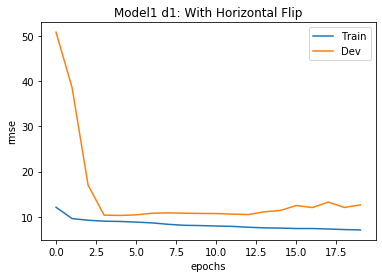

Val RMSE: 10.290844917297363
Train RMSE: 7.088083267211914 
Val Accuracy: 0.9888167381286621
Train Accuracy: 0.9880930781364441 


In [192]:
# Call function to create and fit model2s: With Flipping for D1
train_simple_cnn(X_2s_t_d1, Y_2s_t_d1, X_2s_v_d1, Y_2s_v_d1, 8, \
                 'm2s_d1', 'Model1 d1: With Horizontal Flip', simple_models_history_pd, batch_size=50, epochs=50 )

In [ ]:
m2s_d1.save('model2_flipping_d1.h5')

In [173]:
# Call function to plot metrics of results
#plot_metrics('Model1 d1: With Horizontal Flip', history_m2s_d1)

In [193]:
# Split image examples and facial keypoints labels into train and validation datasets using 80:20 split for d2
X_2s_t_d2, X_2s_v_d2, Y_2s_t_d2, Y_2s_v_d2 = train_test_split(X_train_d2_flip_comb, Y_train_d2_flip_comb, \
                                                              test_size=0.2, random_state=42, shuffle=True)

print("Train: {} {}".format(X_2s_t_d2.shape, Y_2s_t_d2.shape))
print("Val: {} {}".format(X_2s_v_d2.shape, Y_2s_v_d2.shape))

Train: (3414, 96, 96, 1) (3414, 22)
Val: (854, 96, 96, 1) (854, 22)


Train on 3414 samples, validate on 854 samples
Epoch 1/50
 - 4s - loss: 331.2941 - rmse: 17.0429 - accuracy: 0.1166 - val_loss: 2406.2768 - val_rmse: 49.1056 - val_accuracy: 0.0000e+00
Epoch 2/50
 - 4s - loss: 138.2540 - rmse: 11.6654 - accuracy: 0.2252 - val_loss: 2649.1801 - val_rmse: 51.5367 - val_accuracy: 0.2646
Epoch 3/50
 - 4s - loss: 108.4598 - rmse: 10.3074 - accuracy: 0.2856 - val_loss: 2799.7979 - val_rmse: 52.9878 - val_accuracy: 0.2658
Epoch 4/50
 - 4s - loss: 91.9332 - rmse: 9.4767 - accuracy: 0.3354 - val_loss: 2787.1245 - val_rmse: 52.8804 - val_accuracy: 0.3173
Epoch 5/50
 - 4s - loss: 80.6641 - rmse: 8.8761 - accuracy: 0.3582 - val_loss: 2569.1208 - val_rmse: 50.7845 - val_accuracy: 0.3548
Epoch 6/50
 - 4s - loss: 73.6965 - rmse: 8.4914 - accuracy: 0.3673 - val_loss: 2194.0366 - val_rmse: 46.9483 - val_accuracy: 0.4005
Epoch 7/50
 - 3s - loss: 79.3111 - rmse: 8.8325 - accuracy: 0.3284 - val_loss: 1672.8609 - val_rmse: 41.0437 - val_accuracy: 0.4110
Epoch 8/50
 - 3s - 

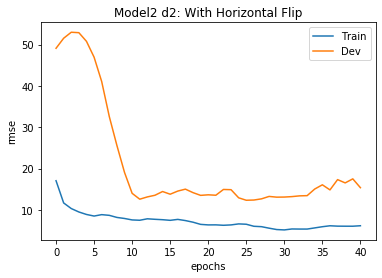

Val RMSE: 12.315801620483398
Train RMSE: 5.135471343994141 
Val Accuracy: 0.41100701689720154
Train Accuracy: 0.5049794912338257 


In [194]:
# Call function to create and fit model2s: With Flipping for D2
train_simple_cnn(X_2s_t_d2, Y_2s_t_d2, X_2s_v_d2, Y_2s_v_d2, 22, \
                 'm2s_d2', 'Model2 d2: With Horizontal Flip', simple_models_history_pd, batch_size=50, epochs=50)

In [185]:
# Call function to plot metrics of results
#plot_metrics('Model2 d2: With Horizontal Flip', history_m2s_d2)

#### 3. With Image Rotation at 5 degrees


In [195]:
# Augment train data for dataset 1 with rotation at 5 degrees to its images and keypoints
X_train_d1_rotate_5_comb = np.concatenate((X_train_d1, X_train_d1_rotate_5.reshape(-1, 96*96)), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d1_rotate_5_comb = np.concatenate((Y_train_d1, Y_train_d1_rotate_5), axis = 0)
print("Train d1 with rotation: {} {}".format(X_train_d1_rotate_5_comb.shape, X_train_d1_rotate_5_comb.shape))

#X_val_d1_rotate_5_comb = X_val_d1.reshape(-1, 96, 96, 1)
#Y_val_d1_rotate_5_comb = Y_val_d1
#print("Val d1 with rotation: {} {}".format(X_val_d1_rotate_5_comb.shape, Y_val_d1_rotate_5_comb.shape))


Train d1 with rotation: (13858, 96, 96, 1) (13858, 96, 96, 1)


In [196]:
# Augment train data for dataset 2 with rotation at 5 degrees to its images and keypoints
X_train_d2_rotate_5_comb = np.concatenate((X_train_d2, X_train_d2_rotate_5.reshape(-1, 96*96)), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d2_rotate_5_comb = np.concatenate((Y_train_d2, Y_train_d2_rotate_5), axis = 0)
print("Train d2 with rotation: {} {}".format(X_train_d2_rotate_5_comb.shape, X_train_d2_rotate_5_comb.shape))


Train d2 with rotation: (4268, 96, 96, 1) (4268, 96, 96, 1)


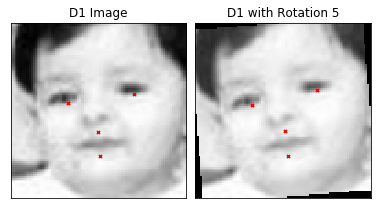

In [197]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 0
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('D1 Image')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='r')

# Plot the rotated image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('D1 with Rotation 5')
ax.imshow(X_train_d1_rotate_5_comb[6929].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_rotate_5_comb[6929, range(0, 8, 2)], Y_train_d1_rotate_5_comb[6929, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

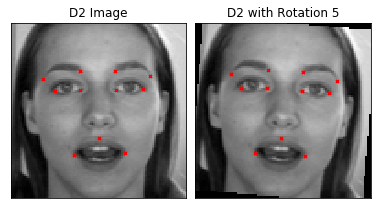

In [198]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 1
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('D2 Image')
ax.imshow(X_train_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2[aug_img_idx, range(0, 22, 2)], Y_train_d2[aug_img_idx, range(1, 22, 2)], marker = 'x', s=10, color='r')

# Plot the rotated image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('D2 with Rotation 5')
ax.imshow(X_train_d2_rotate_5_comb[2135].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2_rotate_5_comb[2135, range(0, 22, 2)], Y_train_d2_rotate_5_comb[2135, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

In [199]:
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_3s_t_d1, X_3s_v_d1, Y_3s_t_d1, Y_3s_v_d1 = train_test_split(X_train_d1_rotate_5_comb, Y_train_d1_rotate_5_comb, \
                                                  test_size=0.2, random_state=42, shuffle=True)

print("Train: {} {}".format(X_3s_t_d1.shape, Y_3s_t_d1.shape))
print("Val: {} {}".format(X_3s_v_d1.shape, Y_3s_v_d1.shape))

Train: (11086, 96, 96, 1) (11086, 8)
Val: (2772, 96, 96, 1) (2772, 8)


Train on 11086 samples, validate on 2772 samples
Epoch 1/50
 - 12s - loss: 72.8699 - rmse: 6.7922 - accuracy: 0.9495 - val_loss: 2726.6833 - val_rmse: 52.2029 - val_accuracy: 0.2118
Epoch 2/50
 - 11s - loss: 18.0679 - rmse: 4.2089 - accuracy: 0.9853 - val_loss: 950.9417 - val_rmse: 30.8214 - val_accuracy: 0.8918
Epoch 3/50
 - 11s - loss: 15.3413 - rmse: 3.8816 - accuracy: 0.9875 - val_loss: 128.3464 - val_rmse: 11.3151 - val_accuracy: 0.9881
Epoch 4/50
 - 11s - loss: 15.2057 - rmse: 3.8671 - accuracy: 0.9860 - val_loss: 16.0767 - val_rmse: 3.9448 - val_accuracy: 0.9895
Epoch 5/50
 - 11s - loss: 14.1412 - rmse: 3.7268 - accuracy: 0.9855 - val_loss: 17.6271 - val_rmse: 4.1438 - val_accuracy: 0.9881
Epoch 6/50
 - 11s - loss: 13.6847 - rmse: 3.6666 - accuracy: 0.9845 - val_loss: 17.9740 - val_rmse: 4.1935 - val_accuracy: 0.9888
Epoch 7/50
 - 11s - loss: 12.7809 - rmse: 3.5426 - accuracy: 0.9861 - val_loss: 17.9019 - val_rmse: 4.1931 - val_accuracy: 0.9812
Epoch 8/50
 - 11s - loss: 11.7430 

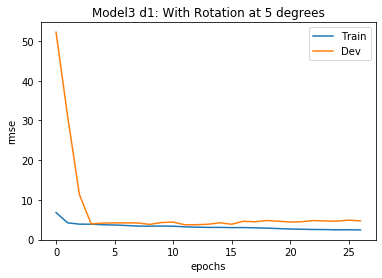

Val RMSE: 3.7238564491271973
Train RMSE: 2.428288698196411 
Val Accuracy: 0.9902597665786743
Train Accuracy: 0.9923326969146729 


In [200]:
# Call function to create and fit model3: With Rotation at 5 degrees for D1
m3s_d1 = train_simple_cnn(X_3s_t_d1, Y_3s_t_d1, X_3s_v_d1, Y_3s_v_d1, 8, \
                 'm3s_d1', 'Model3 d1: With Rotation at 5 degrees', simple_models_history_pd, batch_size=50, epochs=50)

In [201]:
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_3s_t_d2, X_3s_v_d2, Y_3s_t_d2, Y_3s_v_d2 = train_test_split(X_train_d2_rotate_5_comb, Y_train_d2_rotate_5_comb, \
                                                  test_size=0.2, random_state=42, shuffle=True)

print("Train: {} {}".format(X_3s_t_d2.shape, Y_3s_t_d2.shape))
print("Val: {} {}".format(X_3s_v_d2.shape, Y_3s_v_d2.shape))

Train: (3414, 96, 96, 1) (3414, 22)
Val: (854, 96, 96, 1) (854, 22)


Train on 3414 samples, validate on 854 samples
Epoch 1/50
 - 4s - loss: 193.8329 - rmse: 11.2713 - accuracy: 0.4546 - val_loss: 2576.1084 - val_rmse: 50.8007 - val_accuracy: 0.0398
Epoch 2/50
 - 3s - loss: 17.9411 - rmse: 4.1830 - accuracy: 0.7323 - val_loss: 2590.3104 - val_rmse: 50.9516 - val_accuracy: 0.0843
Epoch 3/50
 - 3s - loss: 10.4036 - rmse: 3.2033 - accuracy: 0.7830 - val_loss: 2484.0653 - val_rmse: 49.9118 - val_accuracy: 0.1452
Epoch 4/50
 - 3s - loss: 8.2425 - rmse: 2.8527 - accuracy: 0.7868 - val_loss: 2182.9597 - val_rmse: 46.8021 - val_accuracy: 0.5539
Epoch 5/50
 - 3s - loss: 7.0526 - rmse: 2.6385 - accuracy: 0.7994 - val_loss: 1801.9041 - val_rmse: 42.5347 - val_accuracy: 0.6850
Epoch 6/50
 - 3s - loss: 6.2960 - rmse: 2.4924 - accuracy: 0.8090 - val_loss: 1384.5886 - val_rmse: 37.2982 - val_accuracy: 0.6979
Epoch 7/50
 - 3s - loss: 5.7343 - rmse: 2.3784 - accuracy: 0.8134 - val_loss: 969.5676 - val_rmse: 31.2252 - val_accuracy: 0.7143
Epoch 8/50
 - 3s - loss: 5.3072 

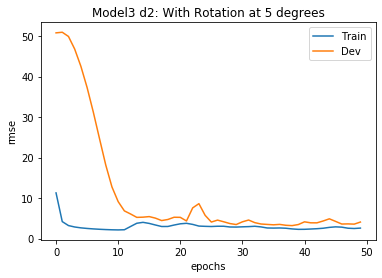

Val RMSE: 3.1921260356903076
Train RMSE: 2.1297500133514404 
Val Accuracy: 0.7915691137313843
Train Accuracy: 0.8204452395439148 


In [202]:
# Call function to create and fit model3: With Rotation at 5 degrees for D2
m3s_d2 = train_simple_cnn(X_3s_t_d2, Y_3s_t_d2, X_3s_v_d2, Y_3s_v_d2, 22, \
                 'm3s_d2', 'Model3 d2: With Rotation at 5 degrees', simple_models_history_pd, batch_size=50, epochs=50)

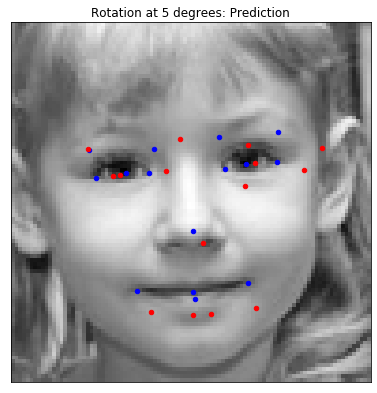

In [225]:
# Using trained model 1 and 2 with augmented data, predict on our pre-defined test data image
model_predict(m3s_d1, m3s_d2, X_test, Y_test, 29, d1_label_indices, d2_label_indices)

# BLUE dots are the given labels from kaggle 
# RED dots are the predictions from our models

#### 4. With Image Rotation at 10 degrees

In [205]:
# Augment train data for dataset 2 with rotation at 10 degrees to its images and keypoints
X_train_d1_rotate_10_comb = np.concatenate((X_train_d1, X_train_d1_rotate_10.reshape(-1, 96*96)), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d1_rotate_10_comb = np.concatenate((Y_train_d1, Y_train_d1_rotate_10), axis = 0)
print("Train d1 with rotation: {} {}".format(X_train_d1_rotate_10_comb.shape, Y_train_d1_rotate_10_comb.shape))



Train d1 with rotation: (13858, 96, 96, 1) (13858, 8)


In [206]:
# Augment train data for dataset 2 with rotation at 10 degrees to its images and keypoints
X_train_d2_rotate_10_comb = np.concatenate((X_train_d2, X_train_d2_rotate_10.reshape(-1, 96*96)), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d2_rotate_10_comb = np.concatenate((Y_train_d2, Y_train_d2_rotate_10), axis = 0)
print("Train d2 with rotation: {} {}".format(X_train_d2_rotate_10_comb.shape, Y_train_d2_rotate_10_comb.shape))


Train d2 with rotation: (4268, 96, 96, 1) (4268, 22)


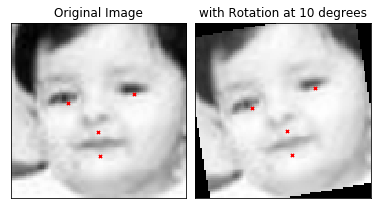

In [207]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 0
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Rotation at 10 degrees')
ax.imshow(X_train_d1_rotate_10_comb[6929].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_rotate_10_comb[6929, range(0, 8, 2)], Y_train_d1_rotate_10_comb[6929, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

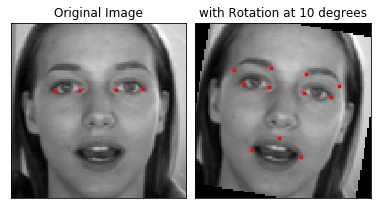

In [208]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 1
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2[aug_img_idx, range(0, 8, 2)], Y_train_d2[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Rotation at 10 degrees')
ax.imshow(X_train_d2_rotate_10_comb[2135].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2_rotate_10_comb[2135, range(0, 22, 2)], Y_train_d2_rotate_10_comb[2135, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

In [209]:
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_4s_t_d1, X_4s_v_d1, Y_4s_t_d1, Y_4s_v_d1 = train_test_split(X_train_d1_rotate_10_comb, Y_train_d1_rotate_10_comb, \
                                                  test_size=0.2, random_state=42, shuffle=True)

print("Train: {} {}".format(X_4s_t_d1.shape, Y_4s_t_d1.shape))
print("Val: {} {}".format(X_4s_v_d1.shape, Y_4s_v_d1.shape))

Train: (11086, 96, 96, 1) (11086, 8)
Val: (2772, 96, 96, 1) (2772, 8)


Train on 11086 samples, validate on 2772 samples
Epoch 1/50
 - 12s - loss: 88.9482 - rmse: 7.3370 - accuracy: 0.9672 - val_loss: 2354.7452 - val_rmse: 48.5076 - val_accuracy: 0.4076
Epoch 2/50
 - 11s - loss: 18.3418 - rmse: 4.2459 - accuracy: 0.9723 - val_loss: 871.3324 - val_rmse: 29.4989 - val_accuracy: 0.6973
Epoch 3/50
 - 11s - loss: 16.3654 - rmse: 4.0103 - accuracy: 0.9655 - val_loss: 106.5721 - val_rmse: 10.3103 - val_accuracy: 0.8795
Epoch 4/50
 - 11s - loss: 15.5260 - rmse: 3.9109 - accuracy: 0.9623 - val_loss: 22.7609 - val_rmse: 4.6742 - val_accuracy: 0.9845
Epoch 5/50
 - 11s - loss: 14.7055 - rmse: 3.7952 - accuracy: 0.9692 - val_loss: 20.4026 - val_rmse: 4.4593 - val_accuracy: 0.9769
Epoch 6/50
 - 11s - loss: 14.3968 - rmse: 3.7579 - accuracy: 0.9745 - val_loss: 17.9468 - val_rmse: 4.1998 - val_accuracy: 0.9589
Epoch 7/50
 - 11s - loss: 13.3765 - rmse: 3.6272 - accuracy: 0.9778 - val_loss: 16.2427 - val_rmse: 3.9912 - val_accuracy: 0.9812
Epoch 8/50
 - 11s - loss: 11.7954 

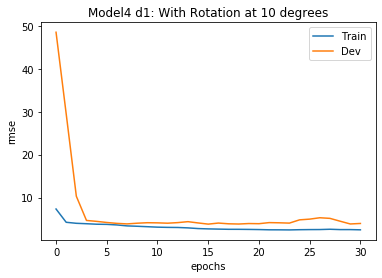

Val RMSE: 3.818267583847046
Train RMSE: 2.4686501026153564 
Val Accuracy: 0.9895382523536682
Train Accuracy: 0.9923326969146729 


In [227]:
# Call function to create and fit model3: With Rotation at 10 degrees for D1
m4s_d1 = train_simple_cnn(X_4s_t_d1, Y_4s_t_d1, X_4s_v_d1, Y_4s_v_d1, 8, \
                 'm4s_d1', 'Model4 d1: With Rotation at 10 degrees', simple_models_history_pd, batch_size=50, epochs=50)

In [ ]:
m4s_d1.save('model4_rotation_d1.h5')

In [ ]:
# Call function to plot metrics of results
#plot_metrics('Model4 d1: With Rotation at 10 degrees', history_m4s_d1)

In [235]:
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_4s_t_d2, X_4s_v_d2, Y_4s_t_d2, Y_4s_v_d2 = train_test_split(X_train_d2_rotate_10_comb, Y_train_d2_rotate_10_comb, \
                                                  test_size=0.2, random_state=42, shuffle=True)

print("Train: {} {}".format(X_4s_t_d2.shape, Y_4s_t_d2.shape))
print("Val: {} {}".format(X_4s_v_d2.shape, Y_4s_v_d2.shape))

Train: (3414, 96, 96, 1) (3414, 22)
Val: (854, 96, 96, 1) (854, 22)


Train on 3414 samples, validate on 854 samples
Epoch 1/50
 - 4s - loss: 163.2763 - rmse: 10.2609 - accuracy: 0.5205 - val_loss: 2628.2926 - val_rmse: 51.3064 - val_accuracy: 0.0000e+00
Epoch 2/50
 - 3s - loss: 19.3126 - rmse: 4.3423 - accuracy: 0.7323 - val_loss: 2733.2241 - val_rmse: 52.3382 - val_accuracy: 0.0000e+00
Epoch 3/50
 - 3s - loss: 12.4343 - rmse: 3.4947 - accuracy: 0.7745 - val_loss: 2602.2941 - val_rmse: 51.1105 - val_accuracy: 0.0246
Epoch 4/50
 - 3s - loss: 10.5450 - rmse: 3.2212 - accuracy: 0.7786 - val_loss: 2234.2702 - val_rmse: 47.4061 - val_accuracy: 0.4274
Epoch 5/50
 - 3s - loss: 10.2295 - rmse: 3.1923 - accuracy: 0.7293 - val_loss: 1773.5447 - val_rmse: 42.2815 - val_accuracy: 0.5211
Epoch 6/50
 - 3s - loss: 15.3587 - rmse: 3.9230 - accuracy: 0.6280 - val_loss: 1291.4982 - val_rmse: 36.0980 - val_accuracy: 0.7096
Epoch 7/50
 - 3s - loss: 17.9036 - rmse: 4.2311 - accuracy: 0.5888 - val_loss: 824.0840 - val_rmse: 28.8513 - val_accuracy: 0.5995
Epoch 8/50
 - 3s - l

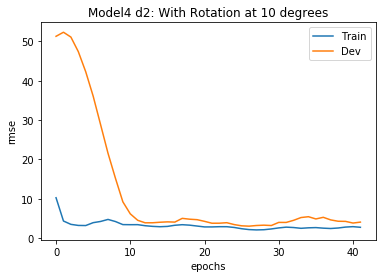

Val RMSE: 3.0349721908569336
Train RMSE: 2.080493688583374 
Val Accuracy: 0.8021077513694763
Train Accuracy: 0.8219097852706909 


In [236]:
# Call function to create and fit model4: With Rotation at 10 degrees for D2
m4s_d2 = train_simple_cnn(X_4s_t_d2, Y_4s_t_d2, X_4s_v_d2, Y_4s_v_d2, 22, \
                 'm4s_d2', 'Model4 d2: With Rotation at 10 degrees', simple_models_history_pd, batch_size=50, epochs=50)

In [ ]:
# Call function to plot metrics of results
#plot_metrics('Model4 d2: With Rotation at 10 degrees', history_m4s_d2)

In [3]:
model_predict(m4s_d1, m4s_d2, X_test, Y_test, 29, d1_label_indices, d2_label_indices, 'Rotation at 5 degrees: Prediction')

#### 5. With Image Rotation at 15 degrees

In [238]:
# Augment train data for dataset 1 with rotation at 15 degrees to its images and keypoints
X_train_d1_rotate_15_comb = np.concatenate((X_train_d1, X_train_d1_rotate_15.reshape(-1, 96*96)), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d1_rotate_15_comb = np.concatenate((Y_train_d1, Y_train_d1_rotate_15), axis = 0)
print("Train d1 with rotation: {} {}".format(X_train_d1_rotate_15_comb.shape, Y_train_d1_rotate_15_comb.shape))

Train d1 with rotation: (13858, 96, 96, 1) (13858, 8)


In [250]:
# Augment train data for dataset 2 with rotation at 5 degrees to its images and keypoints
X_train_d2_rotate_15_comb = np.concatenate((X_train_d2, X_train_d2_rotate_15.reshape(-1, 96*96)), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d2_rotate_15_comb = np.concatenate((Y_train_d2, Y_train_d2_rotate_15), axis = 0)
print("Train d2 with rotation: {} {}".format(X_train_d2_rotate_15_comb.shape, Y_train_d2_rotate_15_comb.shape))

Train d1 with rotation: (4268, 96, 96, 1) (4268, 22)


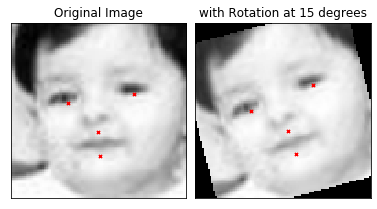

In [240]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 0
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Rotation at 15 degrees')
ax.imshow(X_train_d1_rotate_15_comb[6929].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_rotate_15_comb[6929, range(0, 8, 2)], Y_train_d1_rotate_15_comb[6929, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

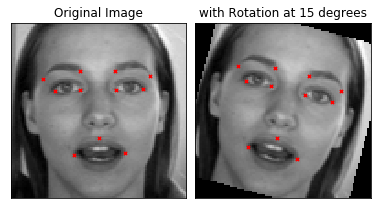

In [268]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 1
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2[aug_img_idx, range(0, 22, 2)], Y_train_d2[aug_img_idx, range(1, 22, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Rotation at 15 degrees')
ax.imshow(X_train_d2_rotate_15_comb[2135].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2_rotate_15_comb[2135, range(0, 22, 2)], Y_train_d2_rotate_15_comb[2135, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

In [245]:
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_5s_t_d1, X_5s_v_d1, Y_5s_t_d1, Y_5s_v_d1 = train_test_split(X_train_d1_rotate_15_comb, Y_train_d1_rotate_15_comb, \
                                                  test_size=0.2, random_state=42, shuffle=True)

print("Train: {} {}".format(X_5s_t_d1.shape, Y_5s_t_d1.shape))
print("Val: {} {}".format(X_5s_v_d1.shape, Y_5s_v_d1.shape))

Train: (11086, 96, 96, 1) (11086, 8)
Val: (2772, 96, 96, 1) (2772, 8)


Train on 11086 samples, validate on 2772 samples
Epoch 1/50
 - 12s - loss: 105.5570 - rmse: 8.5591 - accuracy: 0.9378 - val_loss: 2757.2120 - val_rmse: 52.4977 - val_accuracy: 0.3030
Epoch 2/50
 - 11s - loss: 26.8640 - rmse: 5.1429 - accuracy: 0.9635 - val_loss: 1150.6574 - val_rmse: 33.9022 - val_accuracy: 0.6977
Epoch 3/50
 - 11s - loss: 23.4614 - rmse: 4.8045 - accuracy: 0.9679 - val_loss: 141.9639 - val_rmse: 11.8975 - val_accuracy: 0.8355
Epoch 4/50
 - 11s - loss: 22.5110 - rmse: 4.7070 - accuracy: 0.9663 - val_loss: 23.9982 - val_rmse: 4.8765 - val_accuracy: 0.8654
Epoch 5/50
 - 11s - loss: 20.3274 - rmse: 4.4742 - accuracy: 0.9692 - val_loss: 23.1433 - val_rmse: 4.7836 - val_accuracy: 0.9834
Epoch 6/50
 - 11s - loss: 19.0782 - rmse: 4.3246 - accuracy: 0.9743 - val_loss: 22.1776 - val_rmse: 4.6792 - val_accuracy: 0.9881
Epoch 7/50
 - 11s - loss: 17.3580 - rmse: 4.1270 - accuracy: 0.9806 - val_loss: 21.3911 - val_rmse: 4.5959 - val_accuracy: 0.9877
Epoch 8/50
 - 11s - loss: 16.623

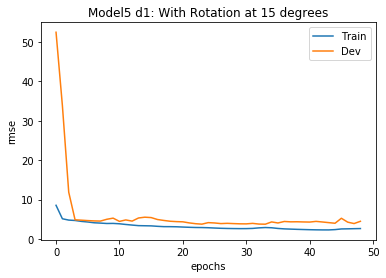

Val RMSE: 3.762141704559326
Train RMSE: 2.311497211456299 
Val Accuracy: 0.988095223903656
Train Accuracy: 0.9906188249588013 


In [246]:
# Call function to create and fit model5: With Rotation at 15 degrees for D1
m5s_d1 = train_simple_cnn(X_5s_t_d1, Y_5s_t_d1, X_5s_v_d1, Y_5s_v_d1, 8, \
                 'm5s_d1', 'Model5 d1: With Rotation at 15 degrees', simple_models_history_pd, batch_size=50, epochs=50)

In [252]:
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_5s_t_d2, X_5s_v_d2, Y_5s_t_d2, Y_5s_v_d2 = train_test_split(X_train_d2_rotate_15_comb, Y_train_d2_rotate_15_comb, \
                                                  test_size=0.2, random_state=42, shuffle=True)

print("Train: {} {}".format(X_5s_t_d2.shape, Y_5s_t_d2.shape))
print("Val: {} {}".format(X_5s_v_d2.shape, Y_5s_v_d2.shape))

Train: (3414, 96, 96, 1) (3414, 22)
Val: (854, 96, 96, 1) (854, 22)


Train on 3414 samples, validate on 854 samples
Epoch 1/50
 - 4s - loss: 215.8161 - rmse: 11.5148 - accuracy: 0.5709 - val_loss: 3021.8011 - val_rmse: 55.0388 - val_accuracy: 0.0000e+00
Epoch 2/50
 - 3s - loss: 15.7949 - rmse: 3.9272 - accuracy: 0.7569 - val_loss: 2997.9222 - val_rmse: 54.9039 - val_accuracy: 0.0035
Epoch 3/50
 - 3s - loss: 9.4577 - rmse: 3.0500 - accuracy: 0.8058 - val_loss: 2588.6159 - val_rmse: 51.1445 - val_accuracy: 0.2131
Epoch 4/50
 - 3s - loss: 7.4343 - rmse: 2.7072 - accuracy: 0.7964 - val_loss: 1979.4178 - val_rmse: 44.8515 - val_accuracy: 0.4052
Epoch 5/50
 - 3s - loss: 7.9556 - rmse: 2.7893 - accuracy: 0.7557 - val_loss: 1360.3025 - val_rmse: 37.2719 - val_accuracy: 0.4672
Epoch 6/50
 - 3s - loss: 22.0176 - rmse: 4.6422 - accuracy: 0.5923 - val_loss: 835.0115 - val_rmse: 29.2604 - val_accuracy: 0.6522
Epoch 7/50
 - 3s - loss: 24.1723 - rmse: 4.8705 - accuracy: 0.5668 - val_loss: 398.8415 - val_rmse: 20.2711 - val_accuracy: 0.7611
Epoch 8/50
 - 3s - loss: 23.

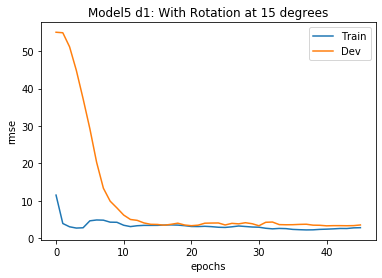

Val RMSE: 3.3047127723693848
Train RMSE: 2.213484287261963 
Val Accuracy: 0.8384075164794922
Train Accuracy: 0.8362624645233154 


In [253]:
# Call function to create and fit model5: With Rotation at 15 degrees for D2
m5s_d2 = train_simple_cnn(X_5s_t_d2, Y_5s_t_d2, X_5s_v_d2, Y_5s_v_d2, 22, \
                 'm5s_d2', 'Model5 d2: With Rotation at 15 degrees', simple_models_history_pd, batch_size=50, epochs=50)

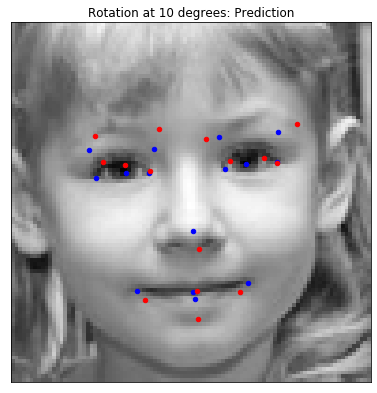

In [294]:
model_predict(m5s_d1, m5s_d2, X_test, Y_test, 29, d1_label_indices, d2_label_indices, 'Rotation at 10 degrees: Prediction')

In [ ]:
m5s_d1.save('model5_rotation_d1.h5')

In [ ]:
# Call function to plot metrics of results
#plot_metrics('Model5 d1: With Rotation at 15 degrees', history_m5s_d1)

#### 5a. With Image Rotation at 12 degrees

From the results of augmenting train data with rotated images and keypoints at 5, 10 and 15 degrees, we see rotation angle of 10 degrees produces best Val. RMSE of 3.2/3.04 using D1 and D2 respectively. Worst Val. RMSE is at 5 degrees. Was curious to see increasing the angle a tad bit will improve results. 

In [259]:
degree = 12
# Create transformed train data for d1 by applying rotation of images and keypoints to D1
X_train_d1_rotate_12 = rotate_images(X_train_d1.reshape(len(X_train_d1), 96, 96, 1), degree, True)
Y_train_d1_rotate_12 = rotate_keypoints(Y_train_d1, degree, 8)

print("Train d1 with rotation: {} {}".format(X_train_d1_rotate_12.shape, Y_train_d1_rotate_12.shape))

Train d1 with rotation: (6929, 96, 96, 1) (6929, 8)


In [260]:
# Create transformed train data for d1 by applying rotation of images and keypoints to D1
X_train_d2_rotate_12 = rotate_images(X_train_d2.reshape(len(X_train_d2), 96, 96, 1), degree, True)
Y_train_d2_rotate_12 = rotate_keypoints(Y_train_d2, degree, 22)

print("Train d2 with rotation: {} {}".format(X_train_d2_rotate_12.shape, Y_train_d2_rotate_12.shape))

Train d2 with rotation: (2134, 96, 96, 1) (2134, 22)


In [262]:
# Augment this with train data which will double the dataset for D1
X_train_d1_rotate_12_comb = np.concatenate((X_train_d1, X_train_d1_rotate_12.reshape(-1, 96*96)), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d1_rotate_12_comb = np.concatenate((Y_train_d1, Y_train_d1_rotate_12), axis = 0)
print("Train d1 with rotation: {} {}".format(X_train_d1_rotate_12_comb.shape, Y_train_d1_rotate_12_comb.shape))

Train d1 with rotation: (13858, 96, 96, 1) (13858, 8)


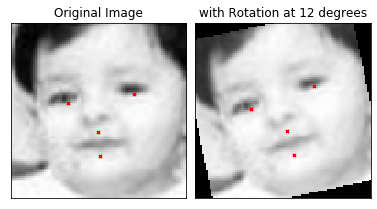

In [263]:
## JUST FOR TESTING
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 0
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Rotation at 12 degrees')
ax.imshow(X_train_d1_rotate_12_comb[6929].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_rotate_12_comb[6929, range(0, 8, 2)], Y_train_d1_rotate_12_comb[6929, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

In [267]:
# Augment this with train data which will double the dataset for D2

X_train_d2_rotate_12_comb = np.concatenate((X_train_d2, X_train_d2_rotate_12.reshape(-1, 96*96)), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d2_rotate_12_comb = np.concatenate((Y_train_d2, Y_train_d2_rotate_12), axis = 0)
print("Train d2 with rotation: {} {}".format(X_train_d2_rotate_12_comb.shape, Y_train_d2_rotate_12_comb.shape))

Train d2 with rotation: (4268, 96, 96, 1) (4268, 22)


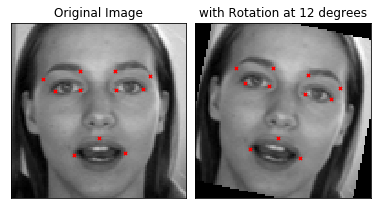

In [269]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 1
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2[aug_img_idx, range(0, 22, 2)], Y_train_d2[aug_img_idx, range(1, 22, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Rotation at 12 degrees')
ax.imshow(X_train_d2_rotate_12_comb[2135].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2_rotate_12_comb[2135, range(0, 22, 2)], Y_train_d2_rotate_12_comb[2135, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

In [270]:
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_5as_t_d1, X_5as_v_d1, Y_5as_t_d1, Y_5as_v_d1 = train_test_split(X_train_d1_rotate_12_comb, Y_train_d1_rotate_12_comb, \
                                                  test_size=0.2, random_state=42, shuffle=True)

print("Train: {} {}".format(X_5as_t_d1.shape, Y_5as_t_d1.shape))
print("Val: {} {}".format(X_5as_v_d1.shape, Y_5as_v_d1.shape))

Train: (11086, 96, 96, 1) (11086, 8)
Val: (2772, 96, 96, 1) (2772, 8)


Train on 11086 samples, validate on 2772 samples
Epoch 1/50
 - 12s - loss: 125.3765 - rmse: 8.4611 - accuracy: 0.9473 - val_loss: 1501.4789 - val_rmse: 38.7316 - val_accuracy: 0.9105
Epoch 2/50
 - 11s - loss: 21.4951 - rmse: 4.5952 - accuracy: 0.9774 - val_loss: 233.0783 - val_rmse: 15.2411 - val_accuracy: 0.9870
Epoch 3/50
 - 11s - loss: 18.4395 - rmse: 4.2579 - accuracy: 0.9784 - val_loss: 36.8538 - val_rmse: 6.0495 - val_accuracy: 0.9830
Epoch 4/50
 - 11s - loss: 17.3012 - rmse: 4.1311 - accuracy: 0.9793 - val_loss: 22.2488 - val_rmse: 4.6848 - val_accuracy: 0.9542
Epoch 5/50
 - 11s - loss: 18.6244 - rmse: 4.2665 - accuracy: 0.9761 - val_loss: 28.1405 - val_rmse: 5.2790 - val_accuracy: 0.8189
Epoch 6/50
 - 11s - loss: 15.9608 - rmse: 3.9579 - accuracy: 0.9824 - val_loss: 20.6927 - val_rmse: 4.5143 - val_accuracy: 0.9459
Epoch 7/50
 - 11s - loss: 14.2902 - rmse: 3.7455 - accuracy: 0.9840 - val_loss: 16.9438 - val_rmse: 4.0711 - val_accuracy: 0.9816
Epoch 8/50
 - 11s - loss: 13.1325 -

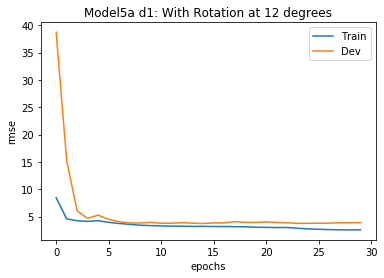

Val RMSE: 3.738687753677368
Train RMSE: 2.573540687561035 
Val Accuracy: 0.988095223903656
Train Accuracy: 0.9916110634803772 


In [272]:
# Call function to create and fit model: With Rotation at 12 degrees for D1
m5as_d1 = train_simple_cnn(X_5as_t_d1, Y_5as_t_d1, X_5s_v_d1, Y_5s_v_d1, 8, \
                 'm5as_d1', 'Model5a d1: With Rotation at 12 degrees', simple_models_history_pd, batch_size=50, epochs=50)

In [273]:
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_5as_t_d2, X_5as_v_d2, Y_5as_t_d2, Y_5as_v_d2 = train_test_split(X_train_d2_rotate_12_comb, Y_train_d2_rotate_12_comb, \
                                                  test_size=0.2, random_state=42, shuffle=True)

print("Train: {} {}".format(X_5as_t_d2.shape, Y_5as_t_d2.shape))
print("Val: {} {}".format(X_5as_v_d2.shape, Y_5as_v_d2.shape))

Train: (3414, 96, 96, 1) (3414, 22)
Val: (854, 96, 96, 1) (854, 22)


Train on 3414 samples, validate on 854 samples
Epoch 1/50
 - 4s - loss: 185.3209 - rmse: 11.3095 - accuracy: 0.5155 - val_loss: 2222.0963 - val_rmse: 47.1867 - val_accuracy: 0.1405
Epoch 2/50
 - 3s - loss: 23.2418 - rmse: 4.7600 - accuracy: 0.7074 - val_loss: 2305.8135 - val_rmse: 48.0754 - val_accuracy: 0.0000e+00
Epoch 3/50
 - 3s - loss: 14.6791 - rmse: 3.7960 - accuracy: 0.7560 - val_loss: 2331.1032 - val_rmse: 48.3589 - val_accuracy: 0.0012
Epoch 4/50
 - 3s - loss: 11.7218 - rmse: 3.3922 - accuracy: 0.7595 - val_loss: 2131.2742 - val_rmse: 46.2740 - val_accuracy: 0.0281
Epoch 5/50
 - 3s - loss: 9.9241 - rmse: 3.1214 - accuracy: 0.7695 - val_loss: 1737.1384 - val_rmse: 41.7956 - val_accuracy: 0.1475
Epoch 6/50
 - 3s - loss: 8.8324 - rmse: 2.9448 - accuracy: 0.7783 - val_loss: 1287.3479 - val_rmse: 35.9925 - val_accuracy: 0.4415
Epoch 7/50
 - 3s - loss: 8.1755 - rmse: 2.8337 - accuracy: 0.7856 - val_loss: 863.6249 - val_rmse: 29.4917 - val_accuracy: 0.6323
Epoch 8/50
 - 3s - loss: 7.

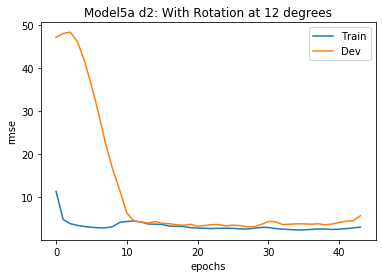

Val RMSE: 3.0753049850463867
Train RMSE: 2.3340938091278076 
Val Accuracy: 0.834894597530365
Train Accuracy: 0.8207381367683411 


In [279]:
# Call function to create and fit model5a: With Rotation at 12 degrees for D2
m5as_d2 = train_simple_cnn(X_5as_t_d2, Y_5as_t_d2, X_5as_v_d2, Y_5as_v_d2, 22, \
                 'm5as_d2', 'Model5a d2: With Rotation at 12 degrees', simple_models_history_pd, batch_size=50, epochs=50)

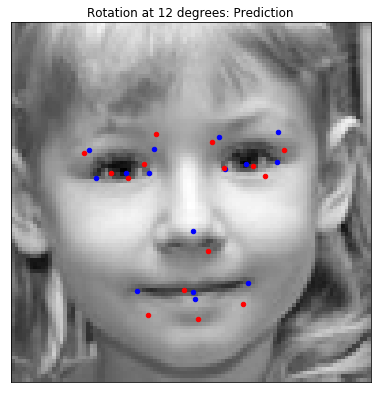

In [280]:
model_predict(m5as_d1, m5as_d2, X_test, Y_test, 29, d1_label_indices, d2_label_indices, 'Rotation at 12 degrees: Prediction')

<b>Rotation - Final Results:</b> Flipping images and keypoints at 10 degrees produced the least Val. RMSE compared to other angles. So we will use this for further steps.

#### 6. With Histogram Equalization

In [281]:
# Augment train data which by applying histogram equalization of its image pixels - will double the dataset for D1
X_train_d1_he_comb = np.concatenate((X_train_d1, X_train_d1_hist_eq), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d1_he_comb = np.concatenate((Y_train_d1, Y_train_d1_hist_eq), axis = 0)
print("Train d1 with hist. eq.: {} {}".format(X_train_d1_he_comb.shape, Y_train_d1_he_comb.shape))

Train d1 with hist. eq.: (13858, 96, 96, 1) (13858, 8)


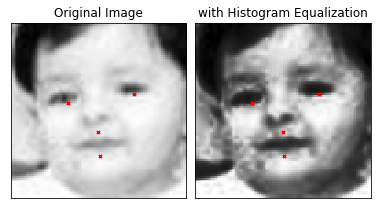

In [282]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 0
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Histogram Equalization')
ax.imshow(X_train_d1_he_comb[6929].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_he_comb[6929, range(0, 8, 2)], Y_train_d1_he_comb[6929, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

In [283]:
# Augment train data which by applying histogram equalization of its image pixels - will double the dataset for D2
X_train_d2_he_comb = np.concatenate((X_train_d2, X_train_d2_hist_eq), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d2_he_comb = np.concatenate((Y_train_d2, Y_train_d2_hist_eq), axis = 0)
print("Train d2 with hist. eq.: {} {}".format(X_train_d2_he_comb.shape, Y_train_d2_he_comb.shape))



Train d2 with hist. eq.: (4268, 96, 96, 1) (4268, 22)


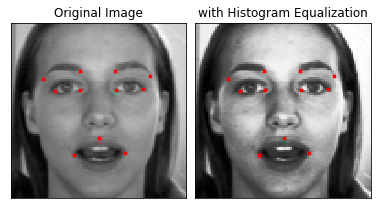

In [284]:
# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 1
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2[aug_img_idx, range(0, 22, 2)], Y_train_d2[aug_img_idx, range(1, 22, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Histogram Equalization')
ax.imshow(X_train_d2_he_comb[2135].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2_he_comb[2135, range(0, 22, 2)], Y_train_d2_he_comb[2135, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

In [285]:
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_6s_t_d1, X_6s_v_d1, Y_6s_t_d1, Y_6s_v_d1 = train_test_split(X_train_d1_he_comb, Y_train_d1_he_comb, \
                                                  test_size=0.2, random_state=42, shuffle=True)

print("Train: {} {}".format(X_6s_t_d1.shape, Y_6s_t_d1.shape))
print("Val: {} {}".format(X_6s_v_d1.shape, Y_6s_v_d1.shape))

Train: (11086, 96, 96, 1) (11086, 8)
Val: (2772, 96, 96, 1) (2772, 8)


Train on 11086 samples, validate on 2772 samples
Epoch 1/50
 - 12s - loss: 93.0580 - rmse: 7.7578 - accuracy: 0.9679 - val_loss: 2482.5791 - val_rmse: 49.8058 - val_accuracy: 0.7882
Epoch 2/50
 - 11s - loss: 21.3602 - rmse: 4.5868 - accuracy: 0.9700 - val_loss: 448.5986 - val_rmse: 21.1627 - val_accuracy: 0.9300
Epoch 3/50
 - 11s - loss: 18.2466 - rmse: 4.2240 - accuracy: 0.9719 - val_loss: 61.9092 - val_rmse: 7.8527 - val_accuracy: 0.9499
Epoch 4/50
 - 11s - loss: 18.2582 - rmse: 4.2281 - accuracy: 0.9603 - val_loss: 29.1845 - val_rmse: 5.3786 - val_accuracy: 0.9805
Epoch 5/50
 - 11s - loss: 13.9156 - rmse: 3.6955 - accuracy: 0.9803 - val_loss: 21.0693 - val_rmse: 4.5602 - val_accuracy: 0.9841
Epoch 6/50
 - 11s - loss: 11.6607 - rmse: 3.3837 - accuracy: 0.9870 - val_loss: 18.7966 - val_rmse: 4.2990 - val_accuracy: 0.9841
Epoch 7/50
 - 11s - loss: 10.8454 - rmse: 3.2596 - accuracy: 0.9879 - val_loss: 20.7445 - val_rmse: 4.5185 - val_accuracy: 0.9787
Epoch 8/50
 - 11s - loss: 11.1279 - 

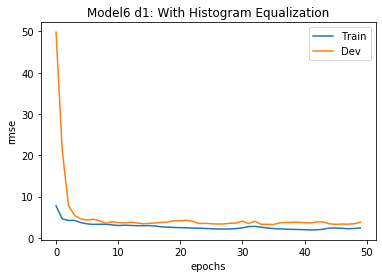

Val RMSE: 3.2353458404541016
Train RMSE: 1.9220619201660156 
Val Accuracy: 0.9913420081138611
Train Accuracy: 0.9938661456108093 


In [286]:
# Call function to create and fit model6: With HE for D1
m6s_d1 = train_simple_cnn(X_6s_t_d1, Y_6s_t_d1, X_6s_v_d1, Y_6s_v_d1, 8, \
                 'm6s_d1', 'Model6 d1: With Histogram Equalization', simple_models_history_pd, batch_size=50, epochs=50)

In [287]:
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_6s_t_d2, X_6s_v_d2, Y_6s_t_d2, Y_6s_v_d2 = train_test_split(X_train_d2_he_comb, Y_train_d2_he_comb, \
                                                  test_size=0.2, random_state=42, shuffle=True)

print("Train: {} {}".format(X_6s_t_d2.shape, Y_6s_t_d2.shape))
print("Val: {} {}".format(X_6s_v_d2.shape, Y_6s_v_d2.shape))

Train: (3414, 96, 96, 1) (3414, 22)
Val: (854, 96, 96, 1) (854, 22)


Train on 3414 samples, validate on 854 samples
Epoch 1/50
 - 4s - loss: 225.6984 - rmse: 12.5483 - accuracy: 0.4965 - val_loss: 1874.5968 - val_rmse: 43.3447 - val_accuracy: 0.1019
Epoch 2/50
 - 3s - loss: 23.2250 - rmse: 4.7414 - accuracy: 0.6385 - val_loss: 2015.0425 - val_rmse: 44.9512 - val_accuracy: 0.0363
Epoch 3/50
 - 3s - loss: 14.5338 - rmse: 3.7484 - accuracy: 0.6942 - val_loss: 2032.1308 - val_rmse: 45.1511 - val_accuracy: 0.0035
Epoch 4/50
 - 3s - loss: 13.4625 - rmse: 3.5982 - accuracy: 0.7071 - val_loss: 1864.0330 - val_rmse: 43.2458 - val_accuracy: 0.1159
Epoch 5/50
 - 3s - loss: 16.2577 - rmse: 3.9583 - accuracy: 0.6816 - val_loss: 1534.4622 - val_rmse: 39.2394 - val_accuracy: 0.4286
Epoch 6/50
 - 3s - loss: 20.6704 - rmse: 4.4799 - accuracy: 0.5943 - val_loss: 1104.7786 - val_rmse: 33.3072 - val_accuracy: 0.6276
Epoch 7/50
 - 3s - loss: 18.8591 - rmse: 4.2787 - accuracy: 0.6403 - val_loss: 756.5027 - val_rmse: 27.5620 - val_accuracy: 0.7834
Epoch 8/50
 - 3s - loss: 18.

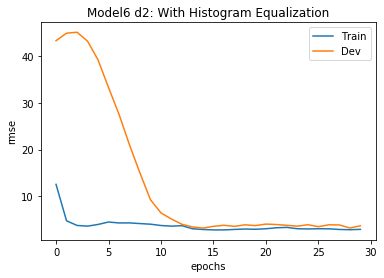

Val RMSE: 3.1833460330963135
Train RMSE: 2.7874064445495605 
Val Accuracy: 0.8196721076965332
Train Accuracy: 0.7967193722724915 


In [288]:
# Call function to create and fit model6: With Histogram Equalization for D2
m6s_d2 = train_simple_cnn(X_6s_t_d2, Y_6s_t_d2, X_6s_v_d2, Y_6s_v_d2, 22, \
                 'm6s_d2', 'Model6 d2: With Histogram Equalization', simple_models_history_pd, batch_size=50, epochs=50)

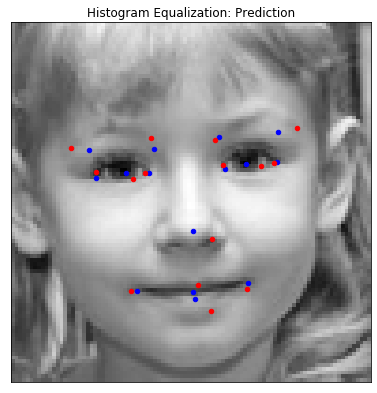

In [298]:
model_predict(m6s_d1, m6s_d2, X_test, Y_test, 29, d1_label_indices, d2_label_indices, 'Histogram Equalization: Prediction')

In [ ]:
m6s_d1.save('model6_hist_eq_d1.h5')

In [ ]:
# Call function to plot metrics of results
#plot_metrics('Model6 d1: With Histogram Equalization', history_m6s_d1)

#### 7. With Gaussian Blurring of Images

In [299]:
# Augment train data which by applying gaussian noise to its image pixels - will double the dataset for D1
X_train_d1_blur_comb = np.concatenate((X_train_d1, X_train_d1_blur.reshape(-1, 96*96)), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d1_blur_comb = np.concatenate((Y_train_d1, Y_train_d1_blur), axis = 0)
print("Train d1 with blurring.: {} {}".format(X_train_d1_blur_comb.shape, Y_train_d1_blur_comb.shape))


Train d1 with blurring.: (13858, 96, 96, 1) (13858, 8)


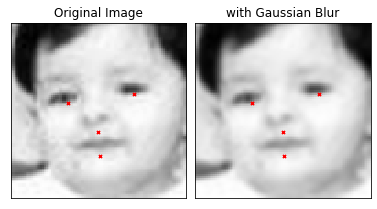

In [300]:
## JUST FOR TESTING
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 0
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Gaussian Blur')
ax.imshow(X_train_d1_blur_comb[6929].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_blur_comb[6929, range(0, 8, 2)], Y_train_d1_blur_comb[6929, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

In [301]:
# Augment train data which by applying gaussian noise to its image pixels - will double the dataset for D2
X_train_d2_blur_comb = np.concatenate((X_train_d2, X_train_d2_blur.reshape(-1, 96*96)), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d2_blur_comb = np.concatenate((Y_train_d2, Y_train_d2_blur), axis = 0)
print("Train d2 with blurring.: {} {}".format(X_train_d2_blur_comb.shape, Y_train_d2_blur_comb.shape))

Train d2 with blurring.: (4268, 96, 96, 1) (4268, 22)


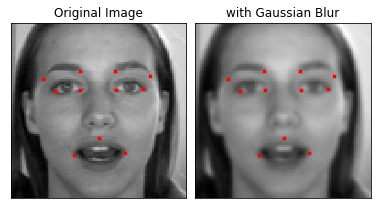

In [302]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 1
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2[aug_img_idx, range(0, 22, 2)], Y_train_d2[aug_img_idx, range(1, 22, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Gaussian Blur')
ax.imshow(X_train_d2_blur_comb[2135].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2_blur_comb[2135, range(0, 22, 2)], Y_train_d2_blur_comb[2135, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

In [303]:
## Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_7s_t_d1, X_7s_v_d1, Y_7s_t_d1, Y_7s_v_d1  = train_test_split(X_train_d1_blur_comb, Y_train_d1_blur_comb, test_size=0.2, \
                                                  random_state=42, shuffle=True)
print("Train: {} {}".format(X_7s_t_d1.shape, Y_7s_t_d1.shape))
print("Val: {} {}".format(X_7s_v_d1.shape, Y_7s_v_d1.shape))

Train: (11086, 96, 96, 1) (11086, 8)
Val: (2772, 96, 96, 1) (2772, 8)


Train on 11086 samples, validate on 2772 samples
Epoch 1/50
 - 12s - loss: 106.6873 - rmse: 8.5647 - accuracy: 0.9520 - val_loss: 1312.8822 - val_rmse: 36.2205 - val_accuracy: 0.9798
Epoch 2/50
 - 11s - loss: 22.2698 - rmse: 4.6781 - accuracy: 0.9800 - val_loss: 398.2972 - val_rmse: 19.9333 - val_accuracy: 0.9802
Epoch 3/50
 - 11s - loss: 16.9781 - rmse: 4.0877 - accuracy: 0.9863 - val_loss: 56.8622 - val_rmse: 7.5199 - val_accuracy: 0.9805
Epoch 4/50
 - 11s - loss: 15.4211 - rmse: 3.8934 - accuracy: 0.9844 - val_loss: 19.4852 - val_rmse: 4.3413 - val_accuracy: 0.9812
Epoch 5/50
 - 11s - loss: 15.3482 - rmse: 3.8800 - accuracy: 0.9845 - val_loss: 18.3615 - val_rmse: 4.1615 - val_accuracy: 0.9733
Epoch 6/50
 - 11s - loss: 15.8345 - rmse: 3.9142 - accuracy: 0.9769 - val_loss: 20.1624 - val_rmse: 4.2947 - val_accuracy: 0.9852
Epoch 7/50
 - 11s - loss: 14.3295 - rmse: 3.7180 - accuracy: 0.9810 - val_loss: 18.7026 - val_rmse: 4.2411 - val_accuracy: 0.9787
Epoch 8/50
 - 11s - loss: 12.1194 -

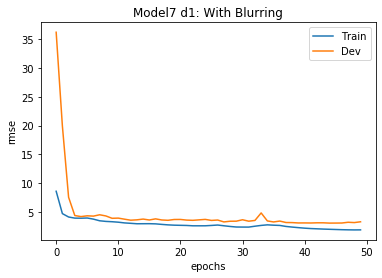

Val RMSE: 3.0269551277160645
Train RMSE: 1.8419663906097412 
Val Accuracy: 0.9902597665786743
Train Accuracy: 0.9939563274383545 


In [304]:
# Call function to create and fit model7: With Blurring for D1
m7s_d1 = train_simple_cnn(X_7s_t_d1, Y_7s_t_d1, X_7s_v_d1, Y_7s_v_d1, 8, \
                 'm7s_d1', 'Model7 d1: With Blurring', simple_models_history_pd, batch_size=50, epochs=50)

In [305]:
## Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_7s_t_d2, X_7s_v_d2, Y_7s_t_d2, Y_7s_v_d2  = train_test_split(X_train_d2_blur_comb, Y_train_d2_blur_comb, test_size=0.2, \
                                                  random_state=42, shuffle=True)
print("Train: {} {}".format(X_7s_t_d2.shape, Y_7s_t_d2.shape))
print("Val: {} {}".format(X_7s_v_d2.shape, Y_7s_v_d2.shape))

Train: (3414, 96, 96, 1) (3414, 22)
Val: (854, 96, 96, 1) (854, 22)


Train on 3414 samples, validate on 854 samples
Epoch 1/50
 - 4s - loss: 149.6378 - rmse: 9.3360 - accuracy: 0.5141 - val_loss: 2688.7930 - val_rmse: 51.9013 - val_accuracy: 0.0012
Epoch 2/50
 - 3s - loss: 12.0582 - rmse: 3.4386 - accuracy: 0.7671 - val_loss: 2416.8737 - val_rmse: 49.1951 - val_accuracy: 0.6452
Epoch 3/50
 - 3s - loss: 7.9580 - rmse: 2.7975 - accuracy: 0.7958 - val_loss: 1972.5987 - val_rmse: 44.4378 - val_accuracy: 0.7681
Epoch 4/50
 - 3s - loss: 6.3138 - rmse: 2.4901 - accuracy: 0.7991 - val_loss: 1551.5536 - val_rmse: 39.4028 - val_accuracy: 0.7529
Epoch 5/50
 - 3s - loss: 5.4077 - rmse: 2.3019 - accuracy: 0.8058 - val_loss: 1181.1909 - val_rmse: 34.3707 - val_accuracy: 0.7436
Epoch 6/50
 - 3s - loss: 4.7746 - rmse: 2.1613 - accuracy: 0.8190 - val_loss: 846.7150 - val_rmse: 29.0936 - val_accuracy: 0.7658
Epoch 7/50
 - 3s - loss: 4.2740 - rmse: 2.0444 - accuracy: 0.8196 - val_loss: 534.0515 - val_rmse: 23.1027 - val_accuracy: 0.7834
Epoch 8/50
 - 3s - loss: 3.8947 - r

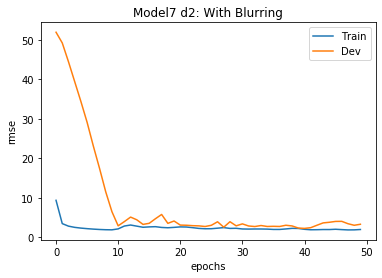

Val RMSE: 2.226780652999878
Train RMSE: 1.8413288593292236 
Val Accuracy: 0.8372365236282349
Train Accuracy: 0.8494434952735901 


In [306]:
# Call function to create and fit model7: With Blurring for D2
m7s_d2 = train_simple_cnn(X_7s_t_d2, Y_7s_t_d2, X_7s_v_d2, Y_7s_v_d2, 22, \
                 'm7s_d2', 'Model7 d2: With Blurring', simple_models_history_pd, batch_size=50, epochs=50)

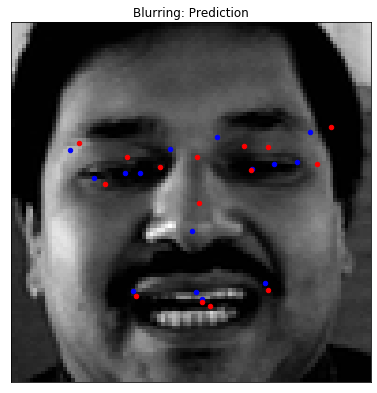

In [311]:
model_predict(m7s_d1, m7s_d2, X_test, Y_test, 12, d1_label_indices, d2_label_indices, 'Blurring: Prediction')

In [ ]:
m7s_d1.save('model7_blur_d1.h5')

In [ ]:
# Call function to plot metrics of results
#plot_metrics('Model7 d1: With Blurring', history_m7s_d1)

<b> Results so far </b>: By applying individual transformations and separately using them to augment train data by doubling its the amount of data, Horizontal Flipping performed the worst with .391/3.78 for D1 and D2. The next three gave better results with following Val. RMSE for D1 and D2:

    - Rotation at 10 degrees: 3.82 / 3.04
    - Histogram Equalization: 3.23 / 2.79
    - Gaussian Noise (Blurring): 3.03 / 2.23
    
<b> Next Steps: </b> Will try applying different combinatiions of the above and augmenting to them to the training datasets D1 and D2 and use our Simple CNN Model for evaluation.

#### 8. Rotate at 10 degrees and Blur

In [312]:
X_train_d1_rotate_10_comb.shape

(13858, 96, 96, 1)

In [315]:
# Combine Rotation and Blurring for D1
X_train_d1_rotate_blur = np.concatenate((X_train_d1_rotate_10_comb, X_train_d1_blur), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d1_rotate_blur = np.concatenate((Y_train_d1_rotate_10_comb, Y_train_d1_blur), axis = 0)

print("Train d1 with rotate+blur: {} {}".format(X_train_d1_rotate_blur.shape, Y_train_d1_rotate_blur.shape))

Train d1 with rotate+blur: (20787, 96, 96, 1) (20787, 8)


In [316]:
# Combine Rotation and Blurring for D2
X_train_d2_rotate_blur = np.concatenate((X_train_d2_rotate_10_comb, X_train_d2_blur), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d2_rotate_blur = np.concatenate((Y_train_d2_rotate_10_comb, Y_train_d2_blur), axis = 0)

print("Train d2 with rotate+blur: {} {}".format(X_train_d2_rotate_blur.shape, Y_train_d2_rotate_blur.shape))

Train d2 with rotate+blur: (6402, 96, 96, 1) (6402, 22)


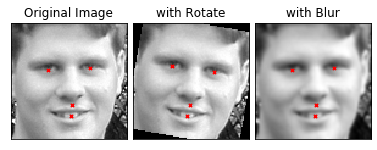

In [323]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 1
# Plot the original image with labels
ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
ax.set_title('with Rotate')
ax.imshow(X_train_d1_rotate_blur[6930].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_rotate_blur[6930, range(0, 8, 2)], Y_train_d1_rotate_blur[6930, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
ax.set_title('with Blur')
ax.imshow(X_train_d1_rotate_blur[13859].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_rotate_blur[13859, range(0, 8, 2)], Y_train_d1_rotate_blur[13859, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

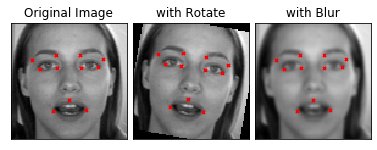

In [329]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 1
# Plot the original image with labels
ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2[aug_img_idx, range(0, 22, 2)], Y_train_d2[aug_img_idx, range(1, 22, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
ax.set_title('with Rotate')
ax.imshow(X_train_d2_rotate_blur[2135].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2_rotate_blur[2135, range(0, 22, 2)], Y_train_d2_rotate_blur[2135, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
ax.set_title('with Blur')
ax.imshow(X_train_d2_rotate_blur[4269].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2_rotate_blur[4269, range(0, 22, 2)], Y_train_d2_rotate_blur[4269, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

In [330]:
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_8s_t_d1, X_8s_v_d1, Y_8s_t_d1, Y_8s_v_d1  = train_test_split(X_train_d1_rotate_blur, Y_train_d1_rotate_blur, test_size=0.2, \
                                                  random_state=42, shuffle=True)
print("Train: {} {}".format(X_8s_t_d1.shape, Y_8s_t_d1.shape))
print("Val: {} {}".format(X_8s_v_d1.shape, Y_8s_v_d1.shape))

Train: (16629, 96, 96, 1) (16629, 8)
Val: (4158, 96, 96, 1) (4158, 8)


Train on 16629 samples, validate on 4158 samples
Epoch 1/50
 - 18s - loss: 66.0620 - rmse: 6.5340 - accuracy: 0.9590 - val_loss: 2142.5003 - val_rmse: 46.2824 - val_accuracy: 0.1830
Epoch 2/50
 - 17s - loss: 13.5393 - rmse: 3.6352 - accuracy: 0.9882 - val_loss: 255.3989 - val_rmse: 15.9825 - val_accuracy: 0.9887
Epoch 3/50
 - 17s - loss: 10.5246 - rmse: 3.2031 - accuracy: 0.9899 - val_loss: 22.5300 - val_rmse: 4.7303 - val_accuracy: 0.9894
Epoch 4/50
 - 17s - loss: 9.3291 - rmse: 3.0130 - accuracy: 0.9907 - val_loss: 15.8317 - val_rmse: 3.9535 - val_accuracy: 0.9897
Epoch 5/50
 - 17s - loss: 8.7355 - rmse: 2.9168 - accuracy: 0.9909 - val_loss: 12.9404 - val_rmse: 3.5649 - val_accuracy: 0.9904
Epoch 6/50
 - 17s - loss: 8.4712 - rmse: 2.8744 - accuracy: 0.9912 - val_loss: 10.7306 - val_rmse: 3.2347 - val_accuracy: 0.9901
Epoch 7/50
 - 17s - loss: 8.3021 - rmse: 2.8475 - accuracy: 0.9907 - val_loss: 10.4526 - val_rmse: 3.1924 - val_accuracy: 0.9901
Epoch 8/50
 - 17s - loss: 7.8606 - rmse:

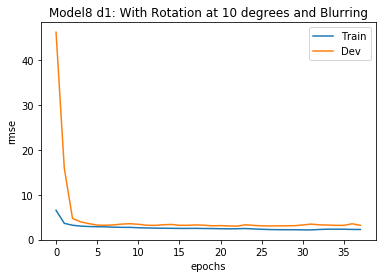

Val RMSE: 3.0035557746887207
Train RMSE: 2.160367965698242 
Val Accuracy: 0.9903799891471863
Train Accuracy: 0.9925431609153748 


In [331]:
# Call function to create and fit model8: With Rotation and Blurring for D1
m8s_d1 = train_simple_cnn(X_8s_t_d1, Y_8s_t_d1, X_8s_v_d1, Y_8s_v_d1, 8, \
                 'm8s_d1', 'Model8 d1: With Rotation at 10 degrees and Blurring', simple_models_history_pd, batch_size=50, epochs=50)

In [332]:
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_8s_t_d2, X_8s_v_d2, Y_8s_t_d2, Y_8s_v_d2  = train_test_split(X_train_d2_rotate_blur, Y_train_d2_rotate_blur, test_size=0.2, \
                                                  random_state=42, shuffle=True)
print("Train: {} {}".format(X_8s_t_d2.shape, Y_8s_t_d2.shape))
print("Val: {} {}".format(X_8s_v_d2.shape, Y_8s_v_d2.shape))

Train: (5121, 96, 96, 1) (5121, 22)
Val: (1281, 96, 96, 1) (1281, 22)


Train on 5121 samples, validate on 1281 samples
Epoch 1/50
 - 6s - loss: 142.1587 - rmse: 9.2307 - accuracy: 0.5852 - val_loss: 2719.3076 - val_rmse: 52.1456 - val_accuracy: 0.0000e+00
Epoch 2/50
 - 5s - loss: 13.6805 - rmse: 3.6512 - accuracy: 0.7432 - val_loss: 2463.4513 - val_rmse: 49.6325 - val_accuracy: 0.0796
Epoch 3/50
 - 5s - loss: 8.2476 - rmse: 2.8544 - accuracy: 0.7819 - val_loss: 1694.5830 - val_rmse: 41.1655 - val_accuracy: 0.4551
Epoch 4/50
 - 5s - loss: 6.5229 - rmse: 2.5405 - accuracy: 0.7907 - val_loss: 973.4753 - val_rmse: 31.2000 - val_accuracy: 0.5301
Epoch 5/50
 - 5s - loss: 6.2926 - rmse: 2.4932 - accuracy: 0.7682 - val_loss: 473.4065 - val_rmse: 21.7572 - val_accuracy: 0.6651
Epoch 6/50
 - 5s - loss: 11.1560 - rmse: 3.3092 - accuracy: 0.6436 - val_loss: 198.7168 - val_rmse: 14.0946 - val_accuracy: 0.5870
Epoch 7/50
 - 5s - loss: 11.3652 - rmse: 3.3525 - accuracy: 0.6421 - val_loss: 62.3296 - val_rmse: 7.8934 - val_accuracy: 0.6339
Epoch 8/50
 - 5s - loss: 11.3267

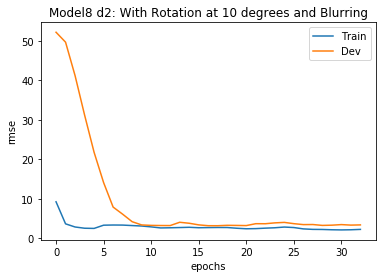

Val RMSE: 3.1745753288269043
Train RMSE: 2.1133618354797363 
Val Accuracy: 0.777517557144165
Train Accuracy: 0.8053114414215088 


In [334]:
# Call function to create and fit model8: With Rotation and Blurring for D2
m8s_d2 = train_simple_cnn(X_8s_t_d2, Y_8s_t_d2, X_8s_v_d2, Y_8s_v_d2, 22, \
                 'm8s_d1', 'Model8 d2: With Rotation at 10 degrees and Blurring', simple_models_history_pd, batch_size=50, epochs=50)

In [ ]:
model_predict(m8s_d1, m8s_d2, X_test, Y_test, 1, d1_label_indices, d2_label_indices, 'Rotation at 10 degrees and Blurring: Prediction')

In [ ]:
# Call function to plot metrics of results
#plot_metrics('Model14 d1: Rotate and Blur', history_m14s_d1)

#### 9. Rotate at 10 degrees + Histogram Equalization

In [349]:
# Combine Rotation and Histogram Equalization for D1
X_train_d1_rotate_he = np.concatenate((X_train_d1_rotate_10_comb, X_train_d1_hist_eq.reshape(-1, 96, 96, 1)), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d1_rotate_he = np.concatenate((Y_train_d1_rotate_10_comb, Y_train_d1_hist_eq), axis = 0)

print("Train d1 with rotate+he: {} {}".format(X_train_d1_rotate_he.shape, Y_train_d1_rotate_he.shape))

Train d1 with rotate+he: (20787, 96, 96, 1) (20787, 8)


In [350]:
# Combine Rotation and Histogram Equalization for D2
X_train_d2_rotate_he = np.concatenate((X_train_d2_rotate_10_comb, X_train_d2_hist_eq.reshape(-1, 96, 96, 1)), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d2_rotate_he = np.concatenate((Y_train_d2_rotate_10_comb, Y_train_d2_hist_eq), axis = 0)

print("Train d2 with rotate+he: {} {}".format(X_train_d2_rotate_he.shape, Y_train_d2_rotate_he.shape))

Train d2 with rotate+he: (6402, 96, 96, 1) (6402, 22)


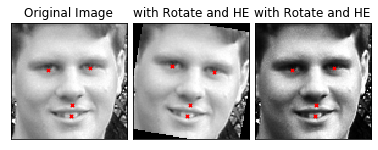

In [351]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 1
# Plot the original image with labels
ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
ax.set_title('with Rotate and HE')
ax.imshow(X_train_d1_rotate_he[6930].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_rotate_he[6930, range(0, 8, 2)], Y_train_d1_rotate_he[6930, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
ax.set_title('with Rotate and HE')
ax.imshow(X_train_d1_rotate_he[13859].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_rotate_he[13859, range(0, 8, 2)], Y_train_d1_rotate_he[13859, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

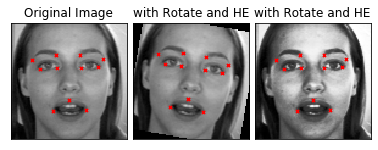

In [352]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 1
# Plot the original image with labels
ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2[aug_img_idx, range(0, 22, 2)], Y_train_d2[aug_img_idx, range(1,22, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
ax.set_title('with Rotate and HE')
ax.imshow(X_train_d2_rotate_he[2135].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2_rotate_he[2135, range(0, 22, 2)], Y_train_d2_rotate_he[2135, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
ax.set_title('with Rotate and HE')
ax.imshow(X_train_d2_rotate_he[4269].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2_rotate_he[4269, range(0, 22, 2)], Y_train_d2_rotate_he[4269, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

In [353]:
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_8s_t_d1, X_8s_v_d1, Y_8s_t_d1, Y_8s_v_d1  = train_test_split(X_train_d1_rotate_he, Y_train_d1_rotate_he, test_size=0.2, \
                                                  random_state=42, shuffle=True)
print("Train: {} {}".format(X_8s_t_d1.shape, Y_8s_t_d1.shape))
print("Val: {} {}".format(X_8s_v_d1.shape, Y_8s_v_d1.shape))

Train: (16629, 96, 96, 1) (16629, 8)
Val: (4158, 96, 96, 1) (4158, 8)


Train on 11086 samples, validate on 2772 samples
Epoch 1/50
 - 12s - loss: 98.3445 - rmse: 8.0056 - accuracy: 0.9406 - val_loss: 2137.1868 - val_rmse: 46.2212 - val_accuracy: 0.3986
Epoch 2/50
 - 11s - loss: 25.9429 - rmse: 5.0339 - accuracy: 0.9517 - val_loss: 833.0136 - val_rmse: 28.8520 - val_accuracy: 0.9430
Epoch 3/50
 - 11s - loss: 24.0585 - rmse: 4.8117 - accuracy: 0.9698 - val_loss: 80.3230 - val_rmse: 8.9480 - val_accuracy: 0.9820
Epoch 4/50
 - 11s - loss: 22.2984 - rmse: 4.6034 - accuracy: 0.9784 - val_loss: 18.1969 - val_rmse: 4.2310 - val_accuracy: 0.9867
Epoch 5/50
 - 11s - loss: 16.9387 - rmse: 4.0412 - accuracy: 0.9846 - val_loss: 24.9295 - val_rmse: 4.9717 - val_accuracy: 0.9867
Epoch 6/50
 - 11s - loss: 14.1950 - rmse: 3.7260 - accuracy: 0.9865 - val_loss: 19.1635 - val_rmse: 4.3479 - val_accuracy: 0.9672
Epoch 7/50
 - 11s - loss: 12.9261 - rmse: 3.5579 - accuracy: 0.9860 - val_loss: 16.2583 - val_rmse: 3.9954 - val_accuracy: 0.9722
Epoch 8/50
 - 11s - loss: 12.2716 - 

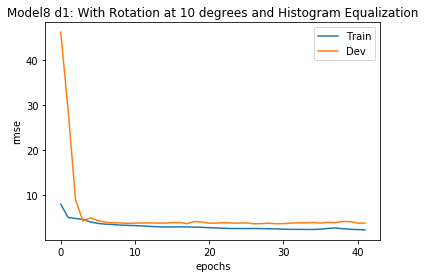

Val RMSE: 3.6364033222198486
Train RMSE: 2.2746376991271973 
Val Accuracy: 0.9884560108184814
Train Accuracy: 0.9907090067863464 


In [354]:
# Call function to create and fit model8: With Rotation at 10 degrees and Histogram Equalization for D1
m8s_d1 = train_simple_cnn(X_5s_t_d1, Y_5s_t_d1, X_5s_v_d1, Y_5s_v_d1, 8, \
                 'm8s_d1', 'Model8 d1: With Rotation at 10 degrees and Histogram Equalization', simple_models_history_pd, batch_size=50, epochs=50)

In [355]:
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_8s_t_d2, X_8s_v_d2, Y_8s_t_d2, Y_8s_v_d2 = train_test_split(X_train_d2_rotate_he, Y_train_d2_rotate_he, test_size=0.2, \
                                                  random_state=42, shuffle=True)
print("Train: {} {}".format(X_8s_t_d2.shape, Y_8s_t_d2.shape))
print("Val: {} {}".format(X_8s_v_d2.shape, Y_8s_v_d2.shape))

Train: (5121, 96, 96, 1) (5121, 22)
Val: (1281, 96, 96, 1) (1281, 22)


Train on 3414 samples, validate on 854 samples
Epoch 1/50
 - 4s - loss: 167.6915 - rmse: 10.2105 - accuracy: 0.5193 - val_loss: 2262.9707 - val_rmse: 47.6222 - val_accuracy: 0.3419
Epoch 2/50
 - 4s - loss: 17.5861 - rmse: 4.1493 - accuracy: 0.7657 - val_loss: 2076.5853 - val_rmse: 45.6288 - val_accuracy: 0.7424
Epoch 3/50
 - 3s - loss: 11.7888 - rmse: 3.4056 - accuracy: 0.7947 - val_loss: 1919.9811 - val_rmse: 43.8862 - val_accuracy: 0.7670
Epoch 4/50
 - 3s - loss: 9.4322 - rmse: 3.0462 - accuracy: 0.8105 - val_loss: 1690.2191 - val_rmse: 41.1889 - val_accuracy: 0.7892
Epoch 5/50
 - 3s - loss: 8.1543 - rmse: 2.8315 - accuracy: 0.8105 - val_loss: 1380.6709 - val_rmse: 37.2371 - val_accuracy: 0.8126
Epoch 6/50
 - 3s - loss: 7.2507 - rmse: 2.6701 - accuracy: 0.8172 - val_loss: 1042.4457 - val_rmse: 32.3656 - val_accuracy: 0.8126
Epoch 7/50
 - 3s - loss: 6.7393 - rmse: 2.5755 - accuracy: 0.8158 - val_loss: 711.5004 - val_rmse: 26.7486 - val_accuracy: 0.7939
Epoch 8/50
 - 3s - loss: 7.1065 

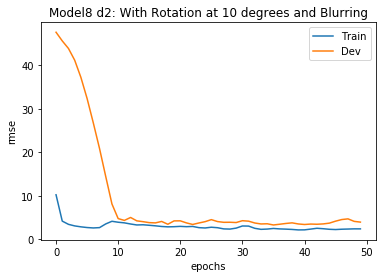

Val RMSE: 3.2591826915740967
Train RMSE: 2.122357130050659 
Val Accuracy: 0.8313817381858826
Train Accuracy: 0.8345049619674683 


In [356]:
# Call function to create and fit model8: With Rotation at 10 degrees and Histogram Equalization for D2
m8s_d2 = train_simple_cnn(X_5s_t_d2, Y_5s_t_d2, X_5s_v_d2, Y_5s_v_d2, 22, \
                 'm8s_d2', 'Model8 d2: With Rotation at 10 degrees and Blurring', simple_models_history_pd, batch_size=50, epochs=50)

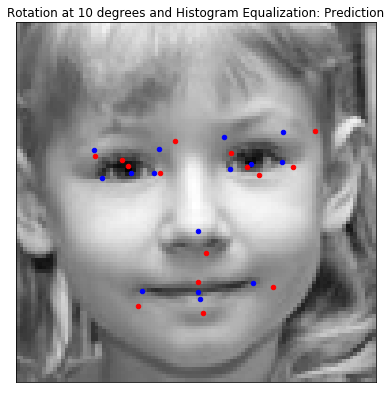

In [372]:
model_predict(m8s_d1, m8s_d2, X_test, Y_test, 29, d1_label_indices, d2_label_indices, 'Rotation at 10 degrees and Histogram Equalization: Prediction')

In [ ]:
m15s_d1.save('model15_rotate_he_d1.h5')

#### 10. Rotate + Histogram Equalization + Blur

In [381]:
# Combine Rotation, Histogram Equalization and Blur for D1
# We have already combined Rotation and HE. Concatenate this with Blur
X_train_d1_rotate_he_blur = np.concatenate((X_train_d1_rotate_blur, X_train_d1_hist_eq.reshape(-1, 96, 96, 1)), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d1_rotate_he_blur = np.concatenate((Y_train_d1_rotate_blur, Y_train_d1_hist_eq), axis = 0)

print("Train d1 with rotate+he+blur: {} {}".format(X_train_d1_rotate_he_blur.shape, Y_train_d1_rotate_he_blur.shape))

Train d1 with rotate+he+blur: (27716, 96, 96, 1) (27716, 8)


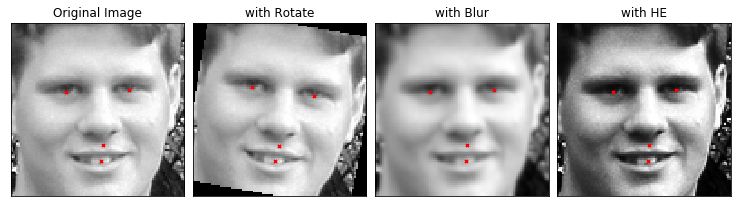

In [382]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 1
# Plot the original image with labels
ax = fig.add_subplot(1, 4, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d1[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1[aug_img_idx, range(0, 8, 2)], Y_train_d1[aug_img_idx, range(1, 8, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 4, 2, xticks=[], yticks=[])
ax.set_title('with Rotate')
ax.imshow(X_train_d1_rotate_he_blur[6930].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_rotate_he_blur[6930, range(0, 8, 2)], Y_train_d1_rotate_he_blur[6930, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 4, 3, xticks=[], yticks=[])
ax.set_title('with Blur')
ax.imshow(X_train_d1_rotate_he_blur[13859].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_rotate_he_blur[13859, range(0, 8, 2)], Y_train_d1_rotate_he_blur[13859, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 4, 4, xticks=[], yticks=[])
ax.set_title('with HE')
ax.imshow(X_train_d1_rotate_he_blur[20788].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d1_rotate_he_blur[20788, range(0, 8, 2)], Y_train_d1_rotate_he_blur[20788, range(1, 8, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

In [383]:
# Combine Rotation, Histogram Equalization and Blur for D2
# We have already combined Rotation and HE. Concatenate this with Blur
X_train_d2_rotate_he_blur = np.concatenate((X_train_d2_rotate_blur, X_train_d2_hist_eq.reshape(-1, 96, 96, 1)), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d2_rotate_he_blur = np.concatenate((Y_train_d2_rotate_blur, Y_train_d2_hist_eq), axis = 0)

print("Train d2 with rotate+he+blur: {} {}".format(X_train_d2_rotate_he_blur.shape, Y_train_d2_rotate_he_blur.shape))

Train d2 with rotate+he+blur: (8536, 96, 96, 1) (8536, 22)


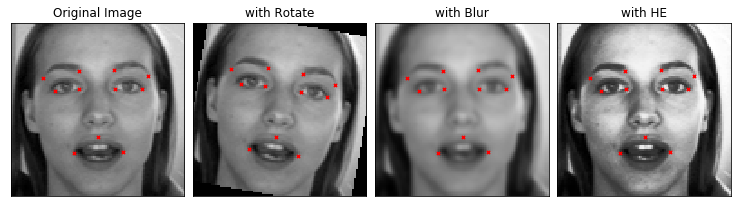

In [384]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

aug_img_idx = 1
# Plot the original image with labels
ax = fig.add_subplot(1, 4, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train_d2[aug_img_idx].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2[aug_img_idx, range(0, 22, 2)], Y_train_d2[aug_img_idx, range(1,22, 2)], marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 4, 2, xticks=[], yticks=[])
ax.set_title('with Rotate')
ax.imshow(X_train_d2_rotate_he_blur[2135].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2_rotate_he_blur[2135, range(0, 22, 2)], Y_train_d2_rotate_he_blur[2135, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 4, 3, xticks=[], yticks=[])
ax.set_title('with Blur')
ax.imshow(X_train_d2_rotate_he_blur[4269].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2_rotate_he_blur[4269, range(0, 22, 2)], Y_train_d2_rotate_he_blur[4269, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')


# Plot the flipped image with labels
ax = fig.add_subplot(1, 4, 4, xticks=[], yticks=[])
ax.set_title('with HE')
ax.imshow(X_train_d2_rotate_he_blur[6403].reshape(96,96),cmap='gray')
ax.scatter(Y_train_d2_rotate_he_blur[6403, range(0, 22, 2)], Y_train_d2_rotate_he_blur[6403, range(1, 22, 2)], \
           marker = 'x', s=10, color='r')

plt.show()

In [385]:
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_9s_t_d1, X_9s_v_d1, Y_9s_t_d1, Y_9s_v_d1 = train_test_split(X_train_d1_rotate_he_blur, Y_train_d1_rotate_he_blur, \
                                                  test_size=0.2, random_state=42, shuffle=True)

print("Train: {} {}".format(X_9s_t_d1.shape, Y_9s_t_d1.shape))
print("Val: {} {}".format(X_9s_v_d1.shape, Y_9s_v_d1.shape))

Train: (22172, 96, 96, 1) (22172, 8)
Val: (5544, 96, 96, 1) (5544, 8)


Train on 22172 samples, validate on 5544 samples
Epoch 1/50
 - 23s - loss: 53.5926 - rmse: 5.9961 - accuracy: 0.9608 - val_loss: 917.0405 - val_rmse: 30.2775 - val_accuracy: 0.9260
Epoch 2/50
 - 22s - loss: 16.6958 - rmse: 4.0486 - accuracy: 0.9832 - val_loss: 15.9533 - val_rmse: 3.9745 - val_accuracy: 0.9903
Epoch 3/50
 - 22s - loss: 12.7913 - rmse: 3.5386 - accuracy: 0.9885 - val_loss: 12.2400 - val_rmse: 3.4730 - val_accuracy: 0.9897
Epoch 4/50
 - 22s - loss: 10.3973 - rmse: 3.1865 - accuracy: 0.9903 - val_loss: 10.2449 - val_rmse: 3.1711 - val_accuracy: 0.9908
Epoch 5/50
 - 22s - loss: 9.3912 - rmse: 3.0257 - accuracy: 0.9903 - val_loss: 11.2581 - val_rmse: 3.3296 - val_accuracy: 0.9879
Epoch 6/50
 - 22s - loss: 8.7423 - rmse: 2.9170 - accuracy: 0.9903 - val_loss: 11.0743 - val_rmse: 3.3037 - val_accuracy: 0.9917
Epoch 7/50
 - 22s - loss: 8.0457 - rmse: 2.7966 - accuracy: 0.9907 - val_loss: 11.2767 - val_rmse: 3.3347 - val_accuracy: 0.9899
Epoch 8/50
 - 22s - loss: 7.6042 - rmse: 2

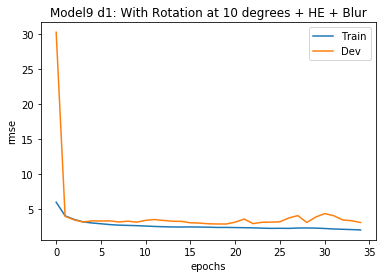

Val RMSE: 2.882126808166504
Train RMSE: 2.0371687412261963 
Val Accuracy: 0.9927849769592285
Train Accuracy: 0.9920169711112976 


In [386]:
# Call function to create and fit model9: With Rotation at 10 degrees + HE +Blur for D1
m9s_d1 = train_simple_cnn(X_9s_t_d1, Y_9s_t_d1, X_9s_v_d1, Y_9s_v_d1, 8, \
                 'm9s_d1', 'Model9 d1: With Rotation at 10 degrees + HE + Blur', simple_models_history_pd, batch_size=50, epochs=50)

In [394]:
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_9s_t_d2, X_9s_v_d2, Y_9s_t_d2, Y_9s_v_d2 = train_test_split(X_train_d2_rotate_he_blur, Y_train_d2_rotate_he_blur, \
                                                  test_size=0.2, random_state=42, shuffle=True)

print("Train: {} {}".format(X_9s_t_d2.shape, Y_9s_t_d2.shape))
print("Val: {} {}".format(X_9s_v_d2.shape, Y_9s_v_d2.shape))

Train: (6828, 96, 96, 1) (6828, 22)
Val: (1708, 96, 96, 1) (1708, 22)


Train on 6828 samples, validate on 1708 samples
Epoch 1/50
 - 8s - loss: 144.9540 - rmse: 8.8438 - accuracy: 0.5933 - val_loss: 2639.4886 - val_rmse: 51.3758 - val_accuracy: 0.5152
Epoch 2/50
 - 7s - loss: 11.4239 - rmse: 3.3505 - accuracy: 0.7679 - val_loss: 2375.1735 - val_rmse: 48.7389 - val_accuracy: 0.5416
Epoch 3/50
 - 7s - loss: 7.8070 - rmse: 2.7775 - accuracy: 0.7961 - val_loss: 1188.2699 - val_rmse: 34.4685 - val_accuracy: 0.7523
Epoch 4/50
 - 7s - loss: 7.0819 - rmse: 2.6408 - accuracy: 0.7901 - val_loss: 285.7030 - val_rmse: 16.8910 - val_accuracy: 0.6528
Epoch 5/50
 - 7s - loss: 9.7685 - rmse: 3.0984 - accuracy: 0.7273 - val_loss: 50.2128 - val_rmse: 7.0714 - val_accuracy: 0.7840
Epoch 6/50
 - 7s - loss: 8.9320 - rmse: 2.9736 - accuracy: 0.7166 - val_loss: 11.3941 - val_rmse: 3.3534 - val_accuracy: 0.5849
Epoch 7/50
 - 7s - loss: 7.6484 - rmse: 2.7533 - accuracy: 0.7213 - val_loss: 8.9690 - val_rmse: 2.9775 - val_accuracy: 0.7892
Epoch 8/50
 - 7s - loss: 6.9592 - rmse: 2.6

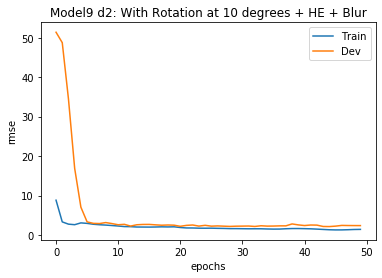

Val RMSE: 2.1654562950134277
Train RMSE: 1.317842721939087 
Val Accuracy: 0.8372365236282349
Train Accuracy: 0.8657000660896301 


In [397]:
# Call function to create and fit model9: With Rotation at 10 degrees + HE + Blur for D2
m9s_d2 = train_simple_cnn(X_9s_t_d2, Y_9s_t_d2, X_9s_v_d2, Y_9s_v_d2, 22, \
                 'm9s_d2', 'Model9 d2: With Rotation at 10 degrees + HE + Blur', simple_models_history_pd, batch_size=50, epochs=50)

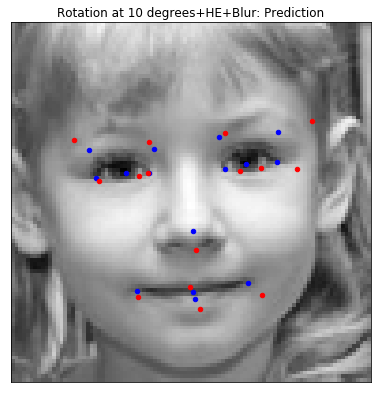

In [398]:
model_predict(m9s_d1, m9s_d2, X_test, Y_test, 29, d1_label_indices, d2_label_indices, 'Rotation at 10 degrees+HE+Blur: Prediction')

In [ ]:
m16s_d1.save('model16_rotate_he_blur_d1.h5')

#### 11. Histogram Equalization + Blur

In [387]:
# Combine Histogram Equalization and Blur for D1
X_train_d1_he_blur = np.concatenate((X_train_d1_rotate_he, X_train_d1_blur), axis = 0).reshape(-1, 96, 96, 1)
Y_train_d1_he_blur = np.concatenate((Y_train_d1_rotate_he, Y_train_d1_blur), axis = 0)

print("Train d1 with he+blur: {} {}".format(X_train_d1_he_blur.shape, Y_train_d1_he_blur.shape))

Train d1 with he+blur: (27716, 96, 96, 1) (27716, 8)


In [388]:
# Combine Histogram Equalization and Blur for D2
X_train_d2_he_blur = np.concatenate((X_train_d2_rotate_he, X_train_d2_blur), axis = 0)
Y_train_d2_he_blur = np.concatenate((Y_train_d2_rotate_he, Y_train_d2_blur), axis = 0)

print("Train d2 with he+blur: {} {}".format(X_train_d2_he_blur.shape, Y_train_d2_he_blur.shape))

Train d2 with he+blur: (8536, 96, 96, 1) (8536, 22)


In [389]:
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_10s_t_d1, X_10s_v_d1, Y_10s_t_d1, Y_10s_v_d1 = train_test_split(X_train_d1_he_blur, Y_train_d1_he_blur, test_size=0.2, \
                                                  random_state=42, shuffle=True)
print("Train: {} {}".format(X_10s_t_d1.shape, Y_10s_t_d1.shape))
print("Val: {} {}".format(X_10s_v_d1.shape, Y_10s_v_d1.shape))

Train: (22172, 96, 96, 1) (22172, 8)
Val: (5544, 96, 96, 1) (5544, 8)


Train on 22172 samples, validate on 5544 samples
Epoch 1/50
 - 23s - loss: 52.0318 - rmse: 6.2384 - accuracy: 0.9526 - val_loss: 1408.2024 - val_rmse: 37.5241 - val_accuracy: 0.7511
Epoch 2/50
 - 22s - loss: 20.1149 - rmse: 4.4420 - accuracy: 0.9716 - val_loss: 26.5326 - val_rmse: 5.1385 - val_accuracy: 0.9609
Epoch 3/50
 - 22s - loss: 16.9340 - rmse: 4.0775 - accuracy: 0.9768 - val_loss: 15.4495 - val_rmse: 3.9113 - val_accuracy: 0.9825
Epoch 4/50
 - 22s - loss: 15.1103 - rmse: 3.8543 - accuracy: 0.9797 - val_loss: 16.0976 - val_rmse: 3.9924 - val_accuracy: 0.9874
Epoch 5/50
 - 22s - loss: 13.5042 - rmse: 3.6386 - accuracy: 0.9874 - val_loss: 17.0236 - val_rmse: 4.1071 - val_accuracy: 0.9908
Epoch 6/50
 - 22s - loss: 12.3243 - rmse: 3.4772 - accuracy: 0.9894 - val_loss: 13.5094 - val_rmse: 3.6528 - val_accuracy: 0.9912
Epoch 7/50
 - 23s - loss: 11.4773 - rmse: 3.3547 - accuracy: 0.9898 - val_loss: 12.6637 - val_rmse: 3.5367 - val_accuracy: 0.9885
Epoch 8/50
 - 23s - loss: 10.6895 - rm

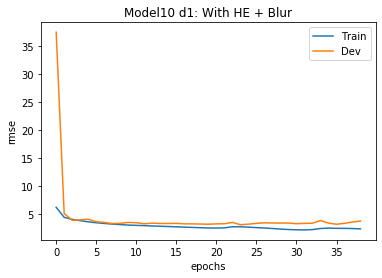

Val RMSE: 3.1159472465515137
Train RMSE: 2.1946215629577637 
Val Accuracy: 0.9927849769592285
Train Accuracy: 0.9919267296791077 


In [390]:
# Call function to create and fit model10: With HE + Blur for D1
m10s_d1 = train_simple_cnn(X_10s_t_d1, Y_10s_t_d1, X_10s_v_d1, Y_10s_v_d1, 8, \
                 'm10s_d1', 'Model10 d1: With HE + Blur', simple_models_history_pd, batch_size=50, epochs=50)

In [391]:
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_10s_t_d2, X_10s_v_d2, Y_10s_t_d2, Y_10s_v_d2 = train_test_split(X_train_d2_he_blur, Y_train_d2_he_blur, test_size=0.2, \
                                                  random_state=42, shuffle=True)
print("Train: {} {}".format(X_10s_t_d2.shape, Y_10s_t_d2.shape))
print("Val: {} {}".format(X_10s_v_d2.shape, Y_10s_v_d2.shape))

Train: (6828, 96, 96, 1) (6828, 22)
Val: (1708, 96, 96, 1) (1708, 22)


Train on 6828 samples, validate on 1708 samples
Epoch 1/50
 - 8s - loss: 106.4275 - rmse: 7.7486 - accuracy: 0.6158 - val_loss: 2292.8158 - val_rmse: 47.8796 - val_accuracy: 0.4391
Epoch 2/50
 - 7s - loss: 13.9732 - rmse: 3.7098 - accuracy: 0.7231 - val_loss: 926.5150 - val_rmse: 30.4109 - val_accuracy: 0.6142
Epoch 3/50
 - 7s - loss: 10.6589 - rmse: 3.2481 - accuracy: 0.7433 - val_loss: 292.9807 - val_rmse: 17.0650 - val_accuracy: 0.6405
Epoch 4/50
 - 7s - loss: 10.0798 - rmse: 3.1632 - accuracy: 0.7274 - val_loss: 79.0193 - val_rmse: 8.8396 - val_accuracy: 0.6417
Epoch 5/50
 - 7s - loss: 14.4643 - rmse: 3.7723 - accuracy: 0.6353 - val_loss: 21.5772 - val_rmse: 4.6122 - val_accuracy: 0.7330
Epoch 6/50
 - 7s - loss: 17.9635 - rmse: 4.2195 - accuracy: 0.5725 - val_loss: 19.2501 - val_rmse: 4.3711 - val_accuracy: 0.5521
Epoch 7/50
 - 7s - loss: 15.5497 - rmse: 3.9247 - accuracy: 0.6276 - val_loss: 14.1986 - val_rmse: 3.7598 - val_accuracy: 0.7564
Epoch 8/50
 - 7s - loss: 9.8734 - rmse: 3

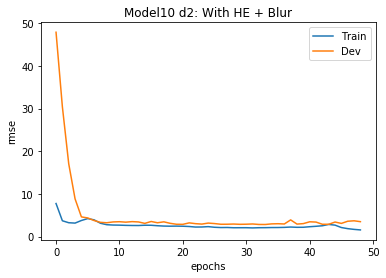

Val RMSE: 2.8360607624053955
Train RMSE: 1.565176248550415 
Val Accuracy: 0.834894597530365
Train Accuracy: 0.8879613280296326 


In [392]:
# Call function to create and fit model10: With HE + Blur for D2
m10s_d2 = train_simple_cnn(X_10s_t_d2, Y_10s_t_d2, X_10s_v_d2, Y_10s_v_d2, 22, \
                 'm10s_d2', 'Model10 d2: With HE + Blur', simple_models_history_pd, batch_size=50, epochs=50)

In [ ]:
m17s_d1.save('model17_he_blur_d1.h5')

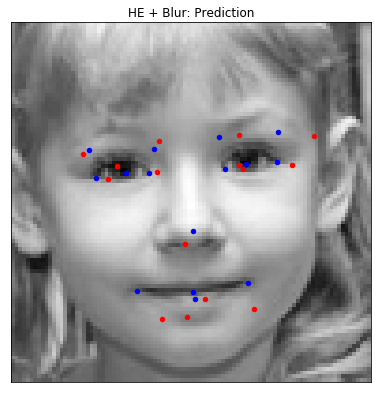

In [400]:
model_predict(m10s_d1, m10s_d2, X_test, Y_test, 29, d1_label_indices, d2_label_indices, 'HE + Blur: Prediction')


<b> Results of combinations of augmentation techniques to train data: </b> By augmenting train data for D1, D2 with different combination transformation techniques, the size of D1 and D2 were <b>doubled</b>(20787-D1, 6402-D2) or <b>tripled</b>(27716-D1, 8536- D2). The following are the results of the performance of our models based on Val. RMSE for D1 and D2:
    
       - 1. Rotate at 10 degrees and Blurring Images(6282 samples): 3.00 / 3.17
       - 2. Rotate at 10 degrees and Histogram Equalization(HE): 3.64 / 3.26
       - 3. Rotate at 10 degrees, HE and Blurring: 2.88 / 2.17
       - 4. Histogram Equalization and Blurring: 3.11 / 2.84
       
<b>Best combination </b>: #3

Next we will use combination #3 to train on our best initial model tested earlier based on VGG-16 inspired architecture and evaluate the performance. 

## Applying Data Augmentation on VGG-16 inspired model

Here we use the same architecture inspired from VGG-16 which produced best Kaggle score based on RMSE.

This architectire has 5 convolutional layers with 64/728/256/1024 filter weights. There are 2 dense layers for the final output with 'linear' activation. Batch Normalization is also used which the original VGG model didn't have as it was not existent that time. Our inspired model however has it which could be of benefit. Max Pooling Layer with a 3X3 patch and stide of (2, 2) is used. This will calculate the max. value in each patch of eacth fetaure map created. The results are down pooled feature maps that highlight the most present feature in a patch. This is preferred over Average pooling for Image processing problems. 

Dropout layer is applied between the hidden layer and the output layer as regularization technique to ignore randomly selected neurons which are ignored during training and any weight updates are not applued to those neurons during back propagation.

Keras' ReduceLRonPLateau is used to reduce the learning rate by a factor of 0.4 on validation loss if it doesn't improve after certain number of epochs(patience = 4). We have set the min. learning rate to 0.00001.

In [401]:
# Function to define the model.
# points -> indices of the keypoints to predict. 8 for dataset 1 and 22 for dataset 2
def VGG_16_2(points):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(96,96,1), data_format='channels_last'))
    model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Conv2D(728, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(256, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Conv2D(512, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(1024, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='linear'))
    model.add(Dropout(0.5))
    model.add(Dense(points))

    return model

##### Prepare the data: Rotation at 10 degrees, Histogram Equalization and Blurring

In [411]:
# Augmented Dataset 1 - Split into train and val for the model
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_1vgg_t_d1, X_1vgg_v_d1, Y_1vgg_t_d1, Y_1vgg_v_d1 = train_test_split(X_train_d1_rotate_he_blur, Y_train_d1_rotate_he_blur, test_size=0.2, \
                                                  random_state=42, shuffle=True)
print("Train: {} {}".format(X_1vgg_t_d1.shape, Y_1vgg_t_d1.shape))
print("Val: {} {}".format(X_1vgg_v_d1.shape, Y_1vgg_v_d1.shape))

Train: (22172, 96, 96, 1) (22172, 8)
Val: (5544, 96, 96, 1) (5544, 8)


====== Model1-VGG d1: With Rotation at 10 degrees + HE + Blur ======= 

Train on 22172 samples, validate on 5544 samples
Epoch 1/50
 - 260s - loss: 108.0225 - rmse: 9.3638 - accuracy: 0.8770 - val_loss: 33.6351 - val_rmse: 5.7816 - val_accuracy: 0.9926
Epoch 2/50
 - 257s - loss: 33.0675 - rmse: 5.6738 - accuracy: 0.9752 - val_loss: 24.4326 - val_rmse: 4.9183 - val_accuracy: 0.9928
Epoch 3/50
 - 257s - loss: 20.3617 - rmse: 4.4693 - accuracy: 0.9898 - val_loss: 12.2573 - val_rmse: 3.4626 - val_accuracy: 0.9928
Epoch 4/50
 - 258s - loss: 16.7931 - rmse: 4.0532 - accuracy: 0.9908 - val_loss: 15.4661 - val_rmse: 3.9027 - val_accuracy: 0.9928
Epoch 5/50
 - 258s - loss: 15.3683 - rmse: 3.8771 - accuracy: 0.9908 - val_loss: 19.5070 - val_rmse: 4.3978 - val_accuracy: 0.9926
Epoch 6/50
 - 258s - loss: 13.9515 - rmse: 3.6971 - accuracy: 0.9906 - val_loss: 30.2778 - val_rmse: 5.4794 - val_accuracy: 0.9928
Epoch 7/50
 - 258s - loss: 13.0679 - rmse: 3.5628 - accuracy: 0.9903 - val_loss: 18.8004 - v

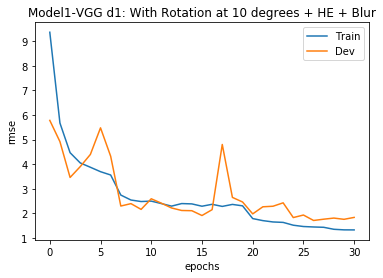

Val RMSE: 1.7147403955459595
Train RMSE: 1.330905795097351 
Val Accuracy: 0.9951298832893372
Train Accuracy: 0.9967526793479919 


AttributeError: module 'pandas' has no attribute 'append'

In [412]:
# Call function to create and fit model vgg 1: With Rotation at 10 degrees + HE +Blur for D1
m1vgg_d1 = train_vgg16_2(X_1vgg_t_d1, Y_1vgg_t_d1, X_1vgg_v_d1, Y_1vgg_v_d1, 8, \
                 'm1vgg_d1', 'Model1-VGG d1: With Rotation at 10 degrees + HE + Blur', cnn_models_history_pd, batch_size=50, epochs=50)

#### VGG-16 Inspired - Highly inefficient!

From the results above, we can see that though the RMSE was better, it is highly inefficient in terms of computational usage and training time. This could be because of the high filters used at each convolutional layer. There doesn't seems to be a smooth convergence either with some spikes on the Val RMSE against number of epochs. Looks like the model found some difficult examples to validate on. However, there was a fair convergence on the train set.

Due to the high computational and training time requirements, we decided to scrap this architecture and didn't bother to train it on D2. Instead we will further look to scale down the architecture to a lighter model and evaluate with augmented data.

DIDN'T EXECUTE THE NEXT STEPS FOR TRAINING ON D2

In [420]:
# Augmented Dataset 2 - Split into train and val for the model
# Split concatenated set of image examples and facial keypoints labels into train and validation datasets using 80:20 split
X_1vgg_t_d2, X_1vgg_v_d2, Y_1vgg_t_d2, Y_1vgg_v_d2 = train_test_split(X_train_d2_rotate_he_blur, Y_train_d2_rotate_he_blur, test_size=0.2, \
                                                  random_state=42, shuffle=True)
print("Train: {} {}".format(X_1vgg_t_d2.shape, Y_1vgg_t_d2.shape))
print("Val: {} {}".format(X_1vgg_v_d2.shape, Y_1vgg_v_d2.shape))

Train: (6828, 96, 96, 1) (6828, 22)
Val: (1708, 96, 96, 1) (1708, 22)


In [ ]:
# Call function to create and fit model vgg 1: With Rotation at 10 degrees + HE +Blur for D2
m1vgg_d2 = train_vgg16_2(X_1vgg_t_d2, Y_1vgg_t_d2, X_1vgg_v_d2, Y_1vgg_v_d2, 8, \
                 'm1vgg_d2', 'Model1-VGG d2: With Rotation at 10 degrees + HE + Blur', cnn_models_history_pd, batch_size=50, epochs=50)

In [ ]:
model_predict(m1vgg_d1, m1vgg_d2, X_test, Y_test, 29, d1_label_indices, d2_label_indices, 'Rotate + HE + Blur: Prediction')